## Identifying cryptocurrency cointegrated pair based on Granger Causality test

In [2]:
#print list of currencies being analyzed and construct the list of currencies symbols

import cryptocompare
coin = cryptocompare.get_coin_list(format=False)

#list the currencies you wish to analyze here
coin_top10 = ['Bitcoin', 'Ethereum ', 'Bitcoin Cash', 'Ripple', 'Litecoin', 'NEM','Monero', 'IOTA', 'Stellar', 'Cardano', 'Tron', 'Komodo', 'Nano', 'EOS', 'Binance Coin', 'NEO', 'Dash', 'QTUM']
coin_top10_sym = []
for key, value in coin.items():
    if value['CoinName'] in coin_top10:
        print(key, value['CoinName'])
        coin_top10_sym.append(key)

ADA Cardano
XMR Monero
DASH Dash
XEM NEM
KMD Komodo
BTC Bitcoin
LTC Litecoin
NANO Nano
EOS EOS
NEO NEO
QTUM QTUM
XLM Stellar
MIOTA IOTA
BCH Bitcoin Cash
BNB Binance Coin


In [24]:
#making API calls to get hourly price data then construct a dataframe of each currencies price data with UNIX timestamp as index

import requests
import json
import pandas as pd
from pandas.io.json import json_normalize

#determine how many rows of data here
lim = '2000' 

df = pd.DataFrame()
for i in coin_top10_sym:
    URL = 'https://min-api.cryptocompare.com/data/histohour?fsym='+i+'&tsym=USD&limit='+lim
    data = requests.get(URL)
    json_data = data.json()
    table = json_normalize(json_data, 'Data').set_index('time')
    table.index = pd.to_datetime(table.index ,unit='s')
    df = pd.concat([df, table.high], axis=1)
df.columns = coin_top10_sym
df.columns

Index(['ADA', 'XMR', 'DASH', 'XEM', 'KMD', 'BTC', 'LTC', 'NANO', 'EOS', 'NEO',
       'QTUM', 'XLM', 'MIOTA', 'BCH', 'BNB'],
      dtype='object')

In [3]:
#df = df.loc[:'2017-11-03', :]

In [11]:
# Performing Dickey-Fuller stationary test

from statsmodels.tsa.stattools import adfuller

for i in df.columns: 
    x = df[i].values
    result = adfuller(x)
    print('\033[1m' + i + '\033[0m')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

ADA
ADF Statistic: -1.5720455300028293
p-value: 0.4976189519932569
XMR
ADF Statistic: 0.01020070918652526
p-value: 0.9593675914975698
DASH
ADF Statistic: -0.7948702116973734
p-value: 0.820624261865798
XEM
ADF Statistic: -1.2289489426592666
p-value: 0.6610203111780037
KMD
ADF Statistic: -2.15139778850947
p-value: 0.22435543535892233
BTC
ADF Statistic: 0.8860401718689199
p-value: 0.9929054155596374
LTC
ADF Statistic: -0.4901610317774978
p-value: 0.8939222464501324
NANO
ADF Statistic: -1.5758426956868443
p-value: 0.49571611966157436
EOS
ADF Statistic: 0.17871922442390012
p-value: 0.9710424421176039
NEO
ADF Statistic: -1.9925157795287016
p-value: 0.2898642800879865
QTUM
ADF Statistic: -2.28532987649174
p-value: 0.1767430387792025
XLM
ADF Statistic: -2.2261845128889957
p-value: 0.19687959908185138
MIOTA
ADF Statistic: -1.264527473739562
p-value: 0.645240824434449
BCH
ADF Statistic: -0.6022914964103845
p-value: 0.8704634014225721
BNB
ADF Statistic: 0.23612270476919126
p-value: 0.974216368679

In [12]:
# Perfrom differencing to stationalize the series

# Creat difference function, with default value of lag 1
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# Differencing the dataset 
df_diff = pd.DataFrame()
for i in df.columns:
    df_diff[i] = difference(df[i])

In [13]:
# Re-perform Dickey-fuller test to test the differenced series for stationality

for i in df.columns: 
    x = df_diff[i].values
    result = adfuller(x)
    print('\033[1m' + i + '\033[0m')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

ADA
ADF Statistic: -8.820748176338146
p-value: 1.8802538096088266e-14
XMR
ADF Statistic: -9.087377417841068
p-value: 3.9070584894033264e-15
DASH
ADF Statistic: -27.886193983051143
p-value: 0.0
XEM
ADF Statistic: -8.58691038051969
p-value: 7.464498407603661e-14
KMD
ADF Statistic: -10.37751969988634
p-value: 2.1819344616143962e-18
BTC
ADF Statistic: -8.944775646198837
p-value: 9.050483479423344e-15
LTC
ADF Statistic: -8.424885273510263
p-value: 1.9388729761548924e-13
NANO
ADF Statistic: -11.545422942434419
p-value: 3.550843554516049e-21
EOS
ADF Statistic: -7.21854748123031
p-value: 2.141191022291444e-10
NEO
ADF Statistic: -8.162121329431285
p-value: 9.084522525501848e-13
QTUM
ADF Statistic: -8.959455270511839
p-value: 8.300410654932381e-15
XLM
ADF Statistic: -24.32147383804048
p-value: 0.0
MIOTA
ADF Statistic: -8.271074498224214
p-value: 4.791583825210056e-13
BCH
ADF Statistic: -8.833090542472043
p-value: 1.7482793253165376e-14
BNB
ADF Statistic: -9.219628279251507
p-value: 1.79453358923

In [14]:
#create dataframes for each of the posible currencies combinations

from itertools import permutations
com = list(permutations(coin_top10_sym, 2))
pair_list = []
count = 0
for i in com:
    globals()[str(i[0]) + '_' + str(i[1])] = df_diff[[com[count][0], com[count][1]]]
    count = count + 1
    pair_list.append(str(i[0]) + '_' + str(i[1]))

In [30]:
# Performing Granger Causality Test

import statsmodels.tsa.stattools as sm
lag = 24
cor = {}
for i in pair_list:
    print(eval(i))
    cor[i] = sm.grangercausalitytests(eval(i), lag)

          ADA   XMR
0     0.00004 -0.28
1     0.00077  0.00
2    -0.00009 -0.01
3    -0.00019  0.23
4     0.00107  1.33
5    -0.00002  0.05
6     0.00020  0.08
7     0.00022  0.53
8    -0.00021 -0.15
9     0.00024  0.12
10    0.00000  0.08
11    0.00014 -0.27
12    0.00019 -0.15
13    0.00020  0.13
14   -0.00082  0.01
15    0.00020  0.26
16   -0.00061 -0.62
17    0.00068  0.20
18    0.00001  0.08
19   -0.00094 -0.31
20    0.00060  0.13
21    0.00016  0.00
22    0.00009  0.16
23   -0.00059  0.06
24    0.00039  0.04
25    0.00034  0.40
26    0.00016 -0.11
27   -0.00028 -0.09
28    0.00015 -0.10
29   -0.00044 -0.03
...       ...   ...
1970 -0.00072 -0.55
1971 -0.00059 -0.33
1972  0.00061  0.27
1973  0.00042  0.43
1974  0.00000  0.09
1975  0.00008 -0.32
1976  0.00109 -0.43
1977  0.00009 -0.06
1978  0.00235  3.32
1979  0.00167  2.40
1980  0.00232  0.00
1981 -0.00078  0.90
1982 -0.00064 -0.44
1983  0.00127  2.17
1984 -0.00039  1.35
1985 -0.00069 -0.67
1986  0.00023 -0.28
1987  0.00001 -0.56


ssr based F test:         F=0.9791  , p=0.4446  , df_denom=1978, df_num=7
ssr based chi2 test:   chi2=6.9057  , p=0.4388  , df=7
likelihood ratio test: chi2=6.8937  , p=0.4400  , df=7
parameter F test:         F=0.9791  , p=0.4446  , df_denom=1978, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8814  , p=0.5313  , df_denom=1975, df_num=8
ssr based chi2 test:   chi2=7.1118  , p=0.5246  , df=8
likelihood ratio test: chi2=7.0992  , p=0.5260  , df=8
parameter F test:         F=0.8814  , p=0.5313  , df_denom=1975, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9401  , p=0.4888  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=8.5424  , p=0.4805  , df=9
likelihood ratio test: chi2=8.5241  , p=0.4823  , df=9
parameter F test:         F=0.9401  , p=0.4888  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9275  , p=0.5065  , df_denom=1969, df_num=10
ssr based ch

ssr based F test:         F=13.1307 , p=0.0000  , df_denom=1963, df_num=12
ssr based chi2 test:   chi2=159.5755, p=0.0000  , df=12
likelihood ratio test: chi2=153.4943, p=0.0000  , df=12
parameter F test:         F=13.1307 , p=0.0000  , df_denom=1963, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=13.3215 , p=0.0000  , df_denom=1960, df_num=13
ssr based chi2 test:   chi2=175.5645, p=0.0000  , df=13
likelihood ratio test: chi2=168.2370, p=0.0000  , df=13
parameter F test:         F=13.3215 , p=0.0000  , df_denom=1960, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=12.2515 , p=0.0000  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=174.0626, p=0.0000  , df=14
likelihood ratio test: chi2=166.8531, p=0.0000  , df=14
parameter F test:         F=12.2515 , p=0.0000  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=11.4624 , p=0.0000  , df_denom=1954, df_num=1

ssr based F test:         F=5.2077  , p=0.0000  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=73.9889 , p=0.0000  , df=14
likelihood ratio test: chi2=72.6440 , p=0.0000  , df=14
parameter F test:         F=5.2077  , p=0.0000  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=4.9835  , p=0.0000  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=75.9392 , p=0.0000  , df=15
likelihood ratio test: chi2=74.5226 , p=0.0000  , df=15
parameter F test:         F=4.9835  , p=0.0000  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=4.6906  , p=0.0000  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=76.3186 , p=0.0000  , df=16
likelihood ratio test: chi2=74.8874 , p=0.0000  , df=16
parameter F test:         F=4.6906  , p=0.0000  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=4.4942  , p=0.0000  , df_denom=1948, df_num=1

ssr based F test:         F=2.0955  , p=0.0066  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=34.0956 , p=0.0053  , df=16
likelihood ratio test: chi2=33.8059 , p=0.0058  , df=16
parameter F test:         F=2.0955  , p=0.0066  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=2.1194  , p=0.0048  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=36.6778 , p=0.0037  , df=17
likelihood ratio test: chi2=36.3428 , p=0.0041  , df=17
parameter F test:         F=2.1194  , p=0.0048  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=2.0121  , p=0.0070  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=36.9072 , p=0.0054  , df=18
likelihood ratio test: chi2=36.5678 , p=0.0060  , df=18
parameter F test:         F=2.0121  , p=0.0070  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=1.9932  , p=0.0065  , df_denom=1942, df_num=1

ssr based F test:         F=6.4322  , p=0.0000  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=104.6552, p=0.0000  , df=16
likelihood ratio test: chi2=101.9883, p=0.0000  , df=16
parameter F test:         F=6.4322  , p=0.0000  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=6.0272  , p=0.0000  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=104.3033, p=0.0000  , df=17
likelihood ratio test: chi2=101.6527, p=0.0000  , df=17
parameter F test:         F=6.0272  , p=0.0000  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=5.7337  , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=105.1701, p=0.0000  , df=18
likelihood ratio test: chi2=102.4748, p=0.0000  , df=18
parameter F test:         F=5.7337  , p=0.0000  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=5.4209  , p=0.0000  , df_denom=1942, df_num=1

likelihood ratio test: chi2=51.1953 , p=0.0000  , df=18
parameter F test:         F=2.8274  , p=0.0001  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=2.6994  , p=0.0001  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=52.3178 , p=0.0001  , df=19
likelihood ratio test: chi2=51.6389 , p=0.0001  , df=19
parameter F test:         F=2.6994  , p=0.0001  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=2.6110  , p=0.0001  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=53.3248 , p=0.0001  , df=20
likelihood ratio test: chi2=52.6193 , p=0.0001  , df=20
parameter F test:         F=2.6110  , p=0.0001  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=2.4948  , p=0.0002  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=53.5538 , p=0.0001  , df=21
likelihood ratio test: chi2=52.8420 , p=0.0001  , df=21
parameter F test:

likelihood ratio test: chi2=107.6695, p=0.0000  , df=20
parameter F test:         F=5.4180  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=5.3570  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=114.9949, p=0.0000  , df=21
likelihood ratio test: chi2=111.7779, p=0.0000  , df=21
parameter F test:         F=5.3570  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=5.0814  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=114.3922, p=0.0000  , df=22
likelihood ratio test: chi2=111.2066, p=0.0000  , df=22
parameter F test:         F=5.0814  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=4.9237  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=116.0023, p=0.0000  , df=23
likelihood ratio test: chi2=112.7266, p=0.0000  , df=23
parameter F test:

ssr based F test:         F=5.9362  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=133.6370, p=0.0000  , df=22
likelihood ratio test: chi2=129.3162, p=0.0000  , df=22
parameter F test:         F=5.9362  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=5.6727  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=133.6493, p=0.0000  , df=23
likelihood ratio test: chi2=129.3256, p=0.0000  , df=23
parameter F test:         F=5.6727  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=5.6888  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=140.0036, p=0.0000  , df=24
likelihood ratio test: chi2=135.2663, p=0.0000  , df=24
parameter F test:         F=5.6888  , p=0.0000  , df_denom=1927, df_num=24
          ADA  QTUM
0     0.00004 -0.01
1     0.00077 -0.01
2    -0.00009  0.01
3    -0.00019  0.01
4     0.00107  0.09


          ADA      XLM
0     0.00004 -0.00001
1     0.00077  0.00005
2    -0.00009  0.00027
3    -0.00019 -0.00043
4     0.00107  0.00048
5    -0.00002  0.00141
6     0.00020 -0.00076
7     0.00022  0.00099
8    -0.00021 -0.00018
9     0.00024 -0.00072
10    0.00000  0.00015
11    0.00014 -0.00011
12    0.00019 -0.00019
13    0.00020  0.00041
14   -0.00082  0.00155
15    0.00020 -0.00176
16   -0.00061 -0.00020
17    0.00068  0.00000
18    0.00001 -0.00010
19   -0.00094 -0.00006
20    0.00060  0.00033
21    0.00016 -0.00015
22    0.00009  0.00052
23   -0.00059 -0.00039
24    0.00039  0.00033
25    0.00034  0.00090
26    0.00016 -0.00128
27   -0.00028  0.00118
28    0.00015 -0.00094
29   -0.00044  0.00082
...       ...      ...
1970 -0.00072 -0.00070
1971 -0.00059 -0.00060
1972  0.00061  0.00050
1973  0.00042  0.00070
1974  0.00000  0.00020
1975  0.00008 -0.00110
1976  0.00109  0.00030
1977  0.00009  0.00040
1978  0.00235  0.00480
1979  0.00167  0.00390
1980  0.00232  0.00160
1981 -0.000

ssr based F test:         F=15.4477 , p=0.0000  , df_denom=1987, df_num=4
ssr based chi2 test:   chi2=62.0705 , p=0.0000  , df=4
likelihood ratio test: chi2=61.1249 , p=0.0000  , df=4
parameter F test:         F=15.4477 , p=0.0000  , df_denom=1987, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=12.7439 , p=0.0000  , df_denom=1984, df_num=5
ssr based chi2 test:   chi2=64.0728 , p=0.0000  , df=5
likelihood ratio test: chi2=63.0654 , p=0.0000  , df=5
parameter F test:         F=12.7439 , p=0.0000  , df_denom=1984, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=10.8266 , p=0.0000  , df_denom=1981, df_num=6
ssr based chi2 test:   chi2=65.3860 , p=0.0000  , df=6
likelihood ratio test: chi2=64.3368 , p=0.0000  , df=6
parameter F test:         F=10.8266 , p=0.0000  , df_denom=1981, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=10.0057 , p=0.0000  , df_denom=1978, df_num=7
ssr based chi2

ssr based F test:         F=6.7013  , p=0.0000  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=60.8930 , p=0.0000  , df=9
likelihood ratio test: chi2=59.9803 , p=0.0000  , df=9
parameter F test:         F=6.7013  , p=0.0000  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.0864  , p=0.0000  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=61.5131 , p=0.0000  , df=10
likelihood ratio test: chi2=60.5815 , p=0.0000  , df=10
parameter F test:         F=6.0864  , p=0.0000  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=6.2525  , p=0.0000  , df_denom=1966, df_num=11
ssr based chi2 test:   chi2=69.5822 , p=0.0000  , df=11
likelihood ratio test: chi2=68.3927 , p=0.0000  , df=11
parameter F test:         F=6.2525  , p=0.0000  , df_denom=1966, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=5.7484  , p=0.0000  , df_denom=1963, df_num=12
ss

ssr based F test:         F=11.5138 , p=0.0000  , df_denom=1960, df_num=13
ssr based chi2 test:   chi2=151.7409, p=0.0000  , df=13
likelihood ratio test: chi2=146.2260, p=0.0000  , df=13
parameter F test:         F=11.5138 , p=0.0000  , df_denom=1960, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=10.8167 , p=0.0000  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=153.6779, p=0.0000  , df=14
likelihood ratio test: chi2=148.0220, p=0.0000  , df=14
parameter F test:         F=10.8167 , p=0.0000  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=10.1244 , p=0.0000  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=154.2755, p=0.0000  , df=15
likelihood ratio test: chi2=148.5739, p=0.0000  , df=15
parameter F test:         F=10.1244 , p=0.0000  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=9.4847  , p=0.0000  , df_denom=1951, df_num=1

likelihood ratio test: chi2=67.4627 , p=0.0000  , df=16
parameter F test:         F=4.2176  , p=0.0000  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=4.0026  , p=0.0000  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=69.2667 , p=0.0000  , df=17
likelihood ratio test: chi2=68.0844 , p=0.0000  , df=17
parameter F test:         F=4.0026  , p=0.0000  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=3.8243  , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=70.1474 , p=0.0000  , df=18
likelihood ratio test: chi2=68.9346 , p=0.0000  , df=18
parameter F test:         F=3.8243  , p=0.0000  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=3.6324  , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=70.4026 , p=0.0000  , df=19
likelihood ratio test: chi2=69.1804 , p=0.0000  , df=19
parameter F test:

ssr based F test:         F=1.2366  , p=0.2222  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=22.6822 , p=0.2031  , df=18
likelihood ratio test: chi2=22.5534 , p=0.2083  , df=18
parameter F test:         F=1.2366  , p=0.2222  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=1.1753  , p=0.2696  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=22.7793 , p=0.2472  , df=19
likelihood ratio test: chi2=22.6494 , p=0.2531  , df=19
parameter F test:         F=1.1753  , p=0.2696  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=1.2061  , p=0.2387  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=24.6329 , p=0.2158  , df=20
likelihood ratio test: chi2=24.4810 , p=0.2220  , df=20
parameter F test:         F=1.2061  , p=0.2387  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=1.2602  , p=0.1911  , df_denom=1936, df_num=2

ssr based F test:         F=8.5759  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=175.1454, p=0.0000  , df=20
likelihood ratio test: chi2=167.8275, p=0.0000  , df=20
parameter F test:         F=8.5759  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=8.2155  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=176.3576, p=0.0000  , df=21
likelihood ratio test: chi2=168.9373, p=0.0000  , df=21
parameter F test:         F=8.2155  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=7.8135  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=175.8990, p=0.0000  , df=22
likelihood ratio test: chi2=168.5127, p=0.0000  , df=22
parameter F test:         F=7.8135  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=7.4964  , p=0.0000  , df_denom=1930, df_num=2

parameter F test:         F=2.5035  , p=0.0001  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=2.4662  , p=0.0001  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=58.1045 , p=0.0001  , df=23
likelihood ratio test: chi2=57.2670 , p=0.0001  , df=23
parameter F test:         F=2.4662  , p=0.0001  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=2.3776  , p=0.0002  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=58.5139 , p=0.0001  , df=24
likelihood ratio test: chi2=57.6643 , p=0.0001  , df=24
parameter F test:         F=2.3776  , p=0.0002  , df_denom=1927, df_num=24
       XMR     BTC
0    -0.28   -2.54
1     0.00   -3.75
2    -0.01    1.51
3     0.23   19.66
4     1.33   90.32
5     0.05   -0.07
6     0.08   -0.29
7     0.53   32.21
8    -0.15  -19.28
9     0.12   -1.72
10    0.08    6.07
11   -0.27   -1.92
12   -0.15  -10.58
13    0.13   -0.73
14    0.01    9.24
15 

       XMR   LTC
0    -0.28  0.00
1     0.00 -0.12
2    -0.01  0.39
3     0.23  2.33
4     1.33  2.85
5     0.05  0.07
6     0.08  0.09
7     0.53  1.93
8    -0.15 -1.41
9     0.12 -0.07
10    0.08 -0.29
11   -0.27  0.07
12   -0.15 -0.11
13    0.13  0.05
14    0.01  0.13
15    0.26  0.71
16   -0.62 -1.24
17    0.20  0.40
18    0.08 -0.01
19   -0.31 -0.48
20    0.13  0.24
21    0.00  0.70
22    0.16  1.19
23    0.06 -0.31
24    0.04  0.02
25    0.40  2.85
26   -0.11 -0.77
27   -0.09 -0.10
28   -0.10 -0.46
29   -0.03 -0.60
...    ...   ...
1970 -0.55 -0.69
1971 -0.33 -0.14
1972  0.27  0.76
1973  0.43  0.00
1974  0.09 -0.54
1975 -0.32  0.10
1976 -0.43  0.07
1977 -0.06 -0.04
1978  3.32  5.29
1979  2.40  2.02
1980  0.00  5.83
1981  0.90 -0.83
1982 -0.44 -0.69
1983  2.17  1.06
1984  1.35 -0.54
1985 -0.67 -0.38
1986 -0.28  2.68
1987 -0.56 -1.46
1988 -0.59 -0.08
1989  0.57  1.36
1990  0.93  0.47
1991 -0.47 -1.72
1992 -0.13  0.29
1993  0.22  0.12
1994 -0.33 -0.21
1995  0.50  1.76
1996  0.25  1.

ssr based F test:         F=10.6249 , p=0.0000  , df_denom=1975, df_num=8
ssr based chi2 test:   chi2=85.7309 , p=0.0000  , df=8
likelihood ratio test: chi2=83.9373 , p=0.0000  , df=8
parameter F test:         F=10.6249 , p=0.0000  , df_denom=1975, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=9.5843  , p=0.0000  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=87.0898 , p=0.0000  , df=9
likelihood ratio test: chi2=85.2389 , p=0.0000  , df=9
parameter F test:         F=9.5843  , p=0.0000  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=8.6209  , p=0.0000  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=87.1287 , p=0.0000  , df=10
likelihood ratio test: chi2=85.2752 , p=0.0000  , df=10
parameter F test:         F=8.6209  , p=0.0000  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=8.2340  , p=0.0000  , df_denom=1966, df_num=11
ssr bas

likelihood ratio test: chi2=70.0774 , p=0.0000  , df=13
parameter F test:         F=5.4122  , p=0.0000  , df_denom=1960, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=5.1938  , p=0.0000  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=73.7906 , p=0.0000  , df=14
likelihood ratio test: chi2=72.4527 , p=0.0000  , df=14
parameter F test:         F=5.1938  , p=0.0000  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=4.8298  , p=0.0000  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=73.5963 , p=0.0000  , df=15
likelihood ratio test: chi2=72.2647 , p=0.0000  , df=15
parameter F test:         F=4.8298  , p=0.0000  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=4.5693  , p=0.0000  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=74.3447 , p=0.0000  , df=16
likelihood ratio test: chi2=72.9856 , p=0.0000  , df=16
parameter F test:

ssr based F test:         F=6.5271  , p=0.0000  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=112.9538, p=0.0000  , df=17
likelihood ratio test: chi2=109.8540, p=0.0000  , df=17
parameter F test:         F=6.5271  , p=0.0000  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=6.2506  , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=114.6512, p=0.0000  , df=18
likelihood ratio test: chi2=111.4577, p=0.0000  , df=18
parameter F test:         F=6.2506  , p=0.0000  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=5.8640  , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=113.6528, p=0.0000  , df=19
likelihood ratio test: chi2=110.5122, p=0.0000  , df=19
parameter F test:         F=5.8640  , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=5.5584  , p=0.0000  , df_denom=1939, df_num=2

ssr based F test:         F=11.1988 , p=0.0000  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=193.7996, p=0.0000  , df=17
likelihood ratio test: chi2=184.9046, p=0.0000  , df=17
parameter F test:         F=11.1988 , p=0.0000  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=10.6654 , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=195.6284, p=0.0000  , df=18
likelihood ratio test: chi2=186.5656, p=0.0000  , df=18
parameter F test:         F=10.6654 , p=0.0000  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=10.0484 , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=194.7535, p=0.0000  , df=19
likelihood ratio test: chi2=185.7648, p=0.0000  , df=19
parameter F test:         F=10.0484 , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=9.7174  , p=0.0000  , df_denom=1939, df_num=2

ssr based F test:         F=1.5020  , p=0.0798  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=27.5499 , p=0.0692  , df=18
likelihood ratio test: chi2=27.3602 , p=0.0725  , df=18
parameter F test:         F=1.5020  , p=0.0798  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=1.5135  , p=0.0714  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=29.3337 , p=0.0609  , df=19
likelihood ratio test: chi2=29.1187 , p=0.0641  , df=19
parameter F test:         F=1.5135  , p=0.0714  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=1.4548  , p=0.0875  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=29.7113 , p=0.0747  , df=20
likelihood ratio test: chi2=29.4906 , p=0.0785  , df=20
parameter F test:         F=1.4548  , p=0.0875  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=1.5426  , p=0.0548  , df_denom=1936, df_num=2

ssr based F test:         F=5.2187  , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=101.1462, p=0.0000  , df=19
likelihood ratio test: chi2=98.6487 , p=0.0000  , df=19
parameter F test:         F=5.2187  , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=4.9571  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=101.2385, p=0.0000  , df=20
likelihood ratio test: chi2=98.7353 , p=0.0000  , df=20
parameter F test:         F=4.9571  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=4.7259  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=101.4485, p=0.0000  , df=21
likelihood ratio test: chi2=98.9339 , p=0.0000  , df=21
parameter F test:         F=4.7259  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=4.6765  , p=0.0000  , df_denom=1933, df_num=2

ssr based F test:         F=3.0408  , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=55.7751 , p=0.0000  , df=18
likelihood ratio test: chi2=55.0048 , p=0.0000  , df=18
parameter F test:         F=3.0408  , p=0.0000  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=3.0904  , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=59.8966 , p=0.0000  , df=19
likelihood ratio test: chi2=59.0090 , p=0.0000  , df=19
parameter F test:         F=3.0904  , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=2.8767  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=58.7499 , p=0.0000  , df=20
likelihood ratio test: chi2=57.8952 , p=0.0000  , df=20
parameter F test:         F=2.8767  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=2.8701  , p=0.0000  , df_denom=1936, df_num=2

likelihood ratio test: chi2=122.4558, p=0.0000  , df=24
parameter F test:         F=5.1332  , p=0.0000  , df_denom=1927, df_num=24
      DASH      ADA
0     0.02  0.00004
1     0.08  0.00077
2    -0.01 -0.00009
3     0.46 -0.00019
4     3.73  0.00107
5     0.24 -0.00002
6    -1.06  0.00020
7     0.17  0.00022
8    -0.10 -0.00021
9     0.22  0.00024
10    0.24  0.00000
11   -0.13  0.00014
12   -0.20  0.00019
13   -0.54  0.00020
14    0.79 -0.00082
15    0.31  0.00020
16   -1.86 -0.00061
17   -0.04  0.00068
18    0.32  0.00001
19   -0.72 -0.00094
20    0.63  0.00060
21    0.29  0.00016
22    0.12  0.00009
23   -0.28 -0.00059
24   -0.12  0.00039
25    1.07  0.00034
26   -0.89  0.00016
27    0.63 -0.00028
28   -0.15  0.00015
29    0.00 -0.00044
...    ...      ...
1970 -0.16 -0.00072
1971 -1.22 -0.00059
1972  0.96  0.00061
1973 -0.01  0.00042
1974 -0.32  0.00000
1975 -0.20  0.00008
1976  0.31  0.00109
1977  0.01  0.00009
1978  5.53  0.00235
1979  3.86  0.00167
1980  2.91  0.00232
1981 -0.0

ssr based F test:         F=16.0214 , p=0.0000  , df_denom=1978, df_num=7
ssr based chi2 test:   chi2=113.0002, p=0.0000  , df=7
likelihood ratio test: chi2=109.9129, p=0.0000  , df=7
parameter F test:         F=16.0214 , p=0.0000  , df_denom=1978, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=14.2031 , p=0.0000  , df_denom=1975, df_num=8
ssr based chi2 test:   chi2=114.6032, p=0.0000  , df=8
likelihood ratio test: chi2=111.4277, p=0.0000  , df=8
parameter F test:         F=14.2031 , p=0.0000  , df_denom=1975, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=12.6966 , p=0.0000  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=115.3704, p=0.0000  , df=9
likelihood ratio test: chi2=112.1515, p=0.0000  , df=9
parameter F test:         F=12.6966 , p=0.0000  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=11.4330 , p=0.0000  , df_denom=1969, df_num=10
ssr based ch

likelihood ratio test: chi2=110.9193, p=0.0000  , df=11
parameter F test:         F=10.2501 , p=0.0000  , df_denom=1966, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=9.4511  , p=0.0000  , df_denom=1963, df_num=12
ssr based chi2 test:   chi2=114.8581, p=0.0000  , df=12
likelihood ratio test: chi2=111.6626, p=0.0000  , df=12
parameter F test:         F=9.4511  , p=0.0000  , df_denom=1963, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=8.8062  , p=0.0000  , df_denom=1960, df_num=13
ssr based chi2 test:   chi2=116.0577, p=0.0000  , df=13
likelihood ratio test: chi2=112.7948, p=0.0000  , df=13
parameter F test:         F=8.8062  , p=0.0000  , df_denom=1960, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=8.1652  , p=0.0000  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=116.0067, p=0.0000  , df=14
likelihood ratio test: chi2=112.7450, p=0.0000  , df=14
parameter F test:

ssr based F test:         F=5.9233  , p=0.0000  , df_denom=1963, df_num=12
ssr based chi2 test:   chi2=71.9848 , p=0.0000  , df=12
likelihood ratio test: chi2=70.7122 , p=0.0000  , df=12
parameter F test:         F=5.9233  , p=0.0000  , df_denom=1963, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=5.4966  , p=0.0000  , df_denom=1960, df_num=13
ssr based chi2 test:   chi2=72.4403 , p=0.0000  , df=13
likelihood ratio test: chi2=71.1511 , p=0.0000  , df=13
parameter F test:         F=5.4966  , p=0.0000  , df_denom=1960, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=5.1084  , p=0.0000  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=72.5769 , p=0.0000  , df=14
likelihood ratio test: chi2=71.2822 , p=0.0000  , df=14
parameter F test:         F=5.1084  , p=0.0000  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=4.7833  , p=0.0000  , df_denom=1954, df_num=1

ssr based F test:         F=8.1810  , p=0.0000  , df_denom=1963, df_num=12
ssr based chi2 test:   chi2=99.4217 , p=0.0000  , df=12
likelihood ratio test: chi2=97.0155 , p=0.0000  , df=12
parameter F test:         F=8.1810  , p=0.0000  , df_denom=1963, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=7.5476  , p=0.0000  , df_denom=1960, df_num=13
ssr based chi2 test:   chi2=99.4699 , p=0.0000  , df=13
likelihood ratio test: chi2=97.0603 , p=0.0000  , df=13
parameter F test:         F=7.5476  , p=0.0000  , df_denom=1960, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=7.0891  , p=0.0000  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=100.7187, p=0.0000  , df=14
likelihood ratio test: chi2=98.2479 , p=0.0000  , df=14
parameter F test:         F=7.0891  , p=0.0000  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=6.6489  , p=0.0000  , df_denom=1954, df_num=1

likelihood ratio test: chi2=152.1236, p=0.0000  , df=20
parameter F test:         F=7.7423  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=7.2972  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=156.6452, p=0.0000  , df=21
likelihood ratio test: chi2=150.7546, p=0.0000  , df=21
parameter F test:         F=7.2972  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=6.9951  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=157.4741, p=0.0000  , df=22
likelihood ratio test: chi2=151.5197, p=0.0000  , df=22
parameter F test:         F=6.9951  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=6.6828  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=157.4477, p=0.0000  , df=23
likelihood ratio test: chi2=151.4923, p=0.0000  , df=23
parameter F test:

ssr based F test:         F=3.4362  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=73.7620 , p=0.0000  , df=21
likelihood ratio test: chi2=72.4206 , p=0.0000  , df=21
parameter F test:         F=3.4362  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=3.3597  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=75.6345 , p=0.0000  , df=22
likelihood ratio test: chi2=74.2243 , p=0.0000  , df=22
parameter F test:         F=3.3597  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=3.2307  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=76.1162 , p=0.0000  , df=23
likelihood ratio test: chi2=74.6874 , p=0.0000  , df=23
parameter F test:         F=3.2307  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=3.0799  , p=0.0000  , df_denom=1927, df_num=2

ssr based F test:         F=7.7175  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=173.7366, p=0.0000  , df=22
likelihood ratio test: chi2=166.5258, p=0.0000  , df=22
parameter F test:         F=7.7175  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=7.3652  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=173.5248, p=0.0000  , df=23
likelihood ratio test: chi2=166.3277, p=0.0000  , df=23
parameter F test:         F=7.3652  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=7.1592  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=176.1893, p=0.0000  , df=24
likelihood ratio test: chi2=168.7721, p=0.0000  , df=24
parameter F test:         F=7.1592  , p=0.0000  , df_denom=1927, df_num=24
      DASH   NEO
0     0.02  0.00
1     0.08  0.06
2    -0.01 -0.02
3     0.46  0.01
4     3.73  0.28
5     0.24  0.00
6

ssr based F test:         F=7.7698  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=191.2162, p=0.0000  , df=24
likelihood ratio test: chi2=182.5210, p=0.0000  , df=24
parameter F test:         F=7.7698  , p=0.0000  , df_denom=1927, df_num=24
      DASH  QTUM
0     0.02 -0.01
1     0.08 -0.01
2    -0.01  0.01
3     0.46  0.01
4     3.73  0.09
5     0.24 -0.04
6    -1.06  0.01
7     0.17  0.03
8    -0.10 -0.02
9     0.22  0.01
10    0.24 -0.01
11   -0.13 -0.02
12   -0.20  0.01
13   -0.54  0.01
14    0.79  0.01
15    0.31 -0.02
16   -1.86  0.00
17   -0.04  0.00
18    0.32 -0.02
19   -0.72  0.01
20    0.63 -0.02
21    0.29  0.03
22    0.12  0.01
23   -0.28  0.00
24   -0.12 -0.01
25    1.07  0.00
26   -0.89  0.03
27    0.63 -0.02
28   -0.15  0.00
29    0.00 -0.02
...    ...   ...
1970 -0.16 -0.03
1971 -1.22  0.00
1972  0.96  0.01
1973 -0.01  0.02
1974 -0.32  0.00
1975 -0.20 -0.01
1976  0.31  0.00
1977  0.01  0.02
1978  5.53  0.13
1979  3.86  0.02
1980  2.91  0.05
1981 -0

parameter F test:         F=9.0380  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=8.6563  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=213.0348, p=0.0000  , df=24
likelihood ratio test: chi2=202.3150, p=0.0000  , df=24
parameter F test:         F=8.6563  , p=0.0000  , df_denom=1927, df_num=24
      DASH      XLM
0     0.02 -0.00001
1     0.08  0.00005
2    -0.01  0.00027
3     0.46 -0.00043
4     3.73  0.00048
5     0.24  0.00141
6    -1.06 -0.00076
7     0.17  0.00099
8    -0.10 -0.00018
9     0.22 -0.00072
10    0.24  0.00015
11   -0.13 -0.00011
12   -0.20 -0.00019
13   -0.54  0.00041
14    0.79  0.00155
15    0.31 -0.00176
16   -1.86 -0.00020
17   -0.04  0.00000
18    0.32 -0.00010
19   -0.72 -0.00006
20    0.63  0.00033
21    0.29 -0.00015
22    0.12  0.00052
23   -0.28 -0.00039
24   -0.12  0.00033
25    1.07  0.00090
26   -0.89 -0.00128
27    0.63  0.00118
28   -0.15 -0.00094
29    0.00  0.00

ssr based F test:         F=9.0371  , p=0.0000  , df_denom=1960, df_num=13
ssr based chi2 test:   chi2=119.1004, p=0.0000  , df=13
likelihood ratio test: chi2=115.6675, p=0.0000  , df=13
parameter F test:         F=9.0371  , p=0.0000  , df_denom=1960, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=8.4425  , p=0.0000  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=119.9460, p=0.0000  , df=14
likelihood ratio test: chi2=116.4634, p=0.0000  , df=14
parameter F test:         F=8.4425  , p=0.0000  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=7.9486  , p=0.0000  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=121.1211, p=0.0000  , df=15
likelihood ratio test: chi2=117.5695, p=0.0000  , df=15
parameter F test:         F=7.9486  , p=0.0000  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=7.4792  , p=0.0000  , df_denom=1951, df_num=1

ssr based F test:         F=4.9956  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=102.0249, p=0.0000  , df=20
likelihood ratio test: chi2=99.4833 , p=0.0000  , df=20
parameter F test:         F=4.9956  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=4.6887  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=100.6490, p=0.0000  , df=21
likelihood ratio test: chi2=98.1732 , p=0.0000  , df=21
parameter F test:         F=4.6887  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=4.4324  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=99.7838 , p=0.0000  , df=22
likelihood ratio test: chi2=97.3484 , p=0.0000  , df=22
parameter F test:         F=4.4324  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=4.2574  , p=0.0000  , df_denom=1930, df_num=2

ssr based F test:         F=6.0640  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=130.1714, p=0.0000  , df=21
likelihood ratio test: chi2=126.0692, p=0.0000  , df=21
parameter F test:         F=6.0640  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=5.8106  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=130.8099, p=0.0000  , df=22
likelihood ratio test: chi2=126.6662, p=0.0000  , df=22
parameter F test:         F=5.8106  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=5.5476  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=130.7024, p=0.0000  , df=23
likelihood ratio test: chi2=126.5634, p=0.0000  , df=23
parameter F test:         F=5.5476  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=5.3028  , p=0.0000  , df_denom=1927, df_num=2

ssr based F test:         F=6.4214  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=151.2878, p=0.0000  , df=23
likelihood ratio test: chi2=145.7785, p=0.0000  , df=23
parameter F test:         F=6.4214  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=6.1781  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=152.0452, p=0.0000  , df=24
likelihood ratio test: chi2=146.4793, p=0.0000  , df=24
parameter F test:         F=6.1781  , p=0.0000  , df_denom=1927, df_num=24
          XEM   XMR
0     0.00003 -0.28
1     0.00000  0.00
2     0.00002 -0.01
3     0.00037  0.23
4     0.00109  1.33
5    -0.00032  0.05
6     0.00006  0.08
7     0.00025  0.53
8     0.00014 -0.15
9    -0.00004  0.12
10    0.00008  0.08
11   -0.00018 -0.27
12   -0.00016 -0.15
13    0.00003  0.13
14    0.00009  0.01
15    0.00035  0.26
16   -0.00036 -0.62
17   -0.00010  0.20
18   -0.00017  0.08
19   -0.00010 -0.31
20    0.0

ssr based F test:         F=5.3932  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=121.4119, p=0.0000  , df=22
likelihood ratio test: chi2=117.8315, p=0.0000  , df=22
parameter F test:         F=5.3932  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=5.3282  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=125.5321, p=0.0000  , df=23
likelihood ratio test: chi2=121.7077, p=0.0000  , df=23
parameter F test:         F=5.3282  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=5.0417  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=124.0784, p=0.0000  , df=24
likelihood ratio test: chi2=120.3385, p=0.0000  , df=24
parameter F test:         F=5.0417  , p=0.0000  , df_denom=1927, df_num=24
          XEM  DASH
0     0.00003  0.02
1     0.00000  0.08
2     0.00002 -0.01
3     0.00037  0.46
4     0.00109  3.73


ssr based F test:         F=1.9115  , p=0.0049  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=47.0415 , p=0.0033  , df=24
likelihood ratio test: chi2=46.4903 , p=0.0039  , df=24
parameter F test:         F=1.9115  , p=0.0049  , df_denom=1927, df_num=24
          XEM     KMD
0     0.00003 -0.0011
1     0.00000 -0.0056
2     0.00002  0.0020
3     0.00037 -0.0012
4     0.00109  0.0335
5    -0.00032  0.0089
6     0.00006  0.0125
7     0.00025  0.0098
8     0.00014 -0.0067
9    -0.00004 -0.0088
10    0.00008  0.0126
11   -0.00018 -0.0036
12   -0.00016  0.0030
13    0.00003 -0.0132
14    0.00009  0.0136
15    0.00035  0.0030
16   -0.00036 -0.0149
17   -0.00010  0.0060
18   -0.00017 -0.0018
19   -0.00010 -0.0099
20    0.00006  0.0070
21    0.00033  0.0063
22    0.00002 -0.0014
23   -0.00012 -0.0030
24    0.00015  0.0008
25    0.00011  0.0023
26   -0.00014 -0.0028
27    0.00017 -0.0019
28   -0.00027 -0.0083
29   -0.00006  0.0015
...       ...     ...
1970 -0.00084 -0.0100
1971 -0.0003

          XEM     BTC
0     0.00003   -2.54
1     0.00000   -3.75
2     0.00002    1.51
3     0.00037   19.66
4     0.00109   90.32
5    -0.00032   -0.07
6     0.00006   -0.29
7     0.00025   32.21
8     0.00014  -19.28
9    -0.00004   -1.72
10    0.00008    6.07
11   -0.00018   -1.92
12   -0.00016  -10.58
13    0.00003   -0.73
14    0.00009    9.24
15    0.00035   10.27
16   -0.00036  -27.71
17   -0.00010    1.22
18   -0.00017    0.04
19   -0.00010   -5.54
20    0.00006    7.13
21    0.00033   10.57
22    0.00002    3.78
23   -0.00012   -7.69
24    0.00015    4.73
25    0.00011   44.89
26   -0.00014  -32.85
27    0.00017   -2.04
28   -0.00027   -5.28
29   -0.00006  -11.04
...       ...     ...
1970 -0.00084  -25.23
1971 -0.00036  -14.58
1972  0.00045   31.71
1973  0.00022   12.86
1974  0.00011    8.98
1975 -0.00034    0.17
1976  0.00011   -5.12
1977  0.00017    2.13
1978  0.00546  571.16
1979 -0.00090  150.52
1980  0.00305  -63.53
1981 -0.00003  107.43
1982 -0.00038  -18.23
1983  0.00

ssr based F test:         F=6.4609  , p=0.0000  , df_denom=1975, df_num=8
ssr based chi2 test:   chi2=52.1324 , p=0.0000  , df=8
likelihood ratio test: chi2=51.4619 , p=0.0000  , df=8
parameter F test:         F=6.4609  , p=0.0000  , df_denom=1975, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=7.2798  , p=0.0000  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=66.1499 , p=0.0000  , df=9
likelihood ratio test: chi2=65.0747 , p=0.0000  , df=9
parameter F test:         F=7.2798  , p=0.0000  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=8.0294  , p=0.0000  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=81.1508 , p=0.0000  , df=10
likelihood ratio test: chi2=79.5398 , p=0.0000  , df=10
parameter F test:         F=8.0294  , p=0.0000  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=8.5862  , p=0.0000  , df_denom=1966, df_num=11
ssr bas

parameter F test:         F=4.3072  , p=0.0000  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.0489  , p=0.0000  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=40.9206 , p=0.0000  , df=10
likelihood ratio test: chi2=40.5056 , p=0.0000  , df=10
parameter F test:         F=4.0489  , p=0.0000  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=4.0502  , p=0.0000  , df_denom=1966, df_num=11
ssr based chi2 test:   chi2=45.0736 , p=0.0000  , df=11
likelihood ratio test: chi2=44.5704 , p=0.0000  , df=11
parameter F test:         F=4.0502  , p=0.0000  , df_denom=1966, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=4.7732  , p=0.0000  , df_denom=1963, df_num=12
ssr based chi2 test:   chi2=58.0076 , p=0.0000  , df=12
likelihood ratio test: chi2=57.1774 , p=0.0000  , df=12
parameter F test:         F=4.7732  , p=0.0000  , df_denom=1963, df_num=12

ssr based F test:         F=11.1493 , p=0.0000  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=101.3107, p=0.0000  , df=9
likelihood ratio test: chi2=98.8174 , p=0.0000  , df=9
parameter F test:         F=11.1493 , p=0.0000  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=10.2841 , p=0.0000  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=103.9376, p=0.0000  , df=10
likelihood ratio test: chi2=101.3142, p=0.0000  , df=10
parameter F test:         F=10.2841 , p=0.0000  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=10.2645 , p=0.0000  , df_denom=1966, df_num=11
ssr based chi2 test:   chi2=114.2300, p=0.0000  , df=11
likelihood ratio test: chi2=111.0702, p=0.0000  , df=11
parameter F test:         F=10.2645 , p=0.0000  , df_denom=1966, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=9.8028  , p=0.0000  , df_denom=1963, df_num=12
ss

parameter F test:         F=9.3610  , p=0.0000  , df_denom=1960, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=8.8707  , p=0.0000  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=126.0303, p=0.0000  , df=14
likelihood ratio test: chi2=122.1929, p=0.0000  , df=14
parameter F test:         F=8.8707  , p=0.0000  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=8.2788  , p=0.0000  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=126.1529, p=0.0000  , df=15
likelihood ratio test: chi2=122.3063, p=0.0000  , df=15
parameter F test:         F=8.2788  , p=0.0000  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=7.9436  , p=0.0000  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=129.2476, p=0.0000  , df=16
likelihood ratio test: chi2=125.2120, p=0.0000  , df=16
parameter F test:         F=7.9436  , p=0.0000  , df_denom=1951, df_num=1

ssr based F test:         F=10.8164 , p=0.0000  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=153.6736, p=0.0000  , df=14
likelihood ratio test: chi2=148.0180, p=0.0000  , df=14
parameter F test:         F=10.8164 , p=0.0000  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=10.2619 , p=0.0000  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=156.3703, p=0.0000  , df=15
likelihood ratio test: chi2=150.5167, p=0.0000  , df=15
parameter F test:         F=10.2619 , p=0.0000  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=10.0477 , p=0.0000  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=163.4820, p=0.0000  , df=16
likelihood ratio test: chi2=157.0951, p=0.0000  , df=16
parameter F test:         F=10.0477 , p=0.0000  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=9.9425  , p=0.0000  , df_denom=1948, df_num=1

ssr based F test:         F=4.6621  , p=0.0000  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=71.0404 , p=0.0000  , df=15
likelihood ratio test: chi2=69.7987 , p=0.0000  , df=15
parameter F test:         F=4.6621  , p=0.0000  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=4.3113  , p=0.0000  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=70.1471 , p=0.0000  , df=16
likelihood ratio test: chi2=68.9355 , p=0.0000  , df=16
parameter F test:         F=4.3113  , p=0.0000  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=4.2409  , p=0.0000  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=73.3901 , p=0.0000  , df=17
likelihood ratio test: chi2=72.0647 , p=0.0000  , df=17
parameter F test:         F=4.2409  , p=0.0000  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=4.1087  , p=0.0000  , df_denom=1945, df_num=1

parameter F test:         F=6.7175  , p=0.0000  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=6.4559  , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=118.4176, p=0.0000  , df=18
likelihood ratio test: chi2=115.0149, p=0.0000  , df=18
parameter F test:         F=6.4559  , p=0.0000  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=6.2357  , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=120.8573, p=0.0000  , df=19
likelihood ratio test: chi2=117.3140, p=0.0000  , df=19
parameter F test:         F=6.2357  , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=5.8541  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=119.5583, p=0.0000  , df=20
likelihood ratio test: chi2=116.0877, p=0.0000  , df=20
parameter F test:         F=5.8541  , p=0.0000  , df_denom=1939, df_num=2

ssr based F test:         F=4.8707  , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=89.3408 , p=0.0000  , df=18
likelihood ratio test: chi2=87.3857 , p=0.0000  , df=18
parameter F test:         F=4.8707  , p=0.0000  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=4.6967  , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=91.0294 , p=0.0000  , df=19
likelihood ratio test: chi2=88.9998 , p=0.0000  , df=19
parameter F test:         F=4.6967  , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=4.5347  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=92.6108 , p=0.0000  , df=20
likelihood ratio test: chi2=90.5102 , p=0.0000  , df=20
parameter F test:         F=4.5347  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=4.2654  , p=0.0000  , df_denom=1936, df_num=2

parameter F test:         F=7.9148  , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=7.5070  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=153.3148, p=0.0000  , df=20
likelihood ratio test: chi2=147.6687, p=0.0000  , df=20
parameter F test:         F=7.5070  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=7.2039  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=154.6420, p=0.0000  , df=21
likelihood ratio test: chi2=148.8974, p=0.0000  , df=21
parameter F test:         F=7.2039  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=7.1158  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=160.1917, p=0.0000  , df=22
likelihood ratio test: chi2=154.0352, p=0.0000  , df=22
parameter F test:         F=7.1158  , p=0.0000  , df_denom=1933, df_num=2

ssr based F test:         F=0.8302  , p=0.6656  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=15.2278 , p=0.6463  , df=18
likelihood ratio test: chi2=15.1696 , p=0.6503  , df=18
parameter F test:         F=0.8302  , p=0.6656  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=0.9275  , p=0.5479  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=17.9766 , p=0.5240  , df=19
likelihood ratio test: chi2=17.8955 , p=0.5294  , df=19
parameter F test:         F=0.9275  , p=0.5479  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=0.9106  , p=0.5735  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=18.5979 , p=0.5481  , df=20
likelihood ratio test: chi2=18.5111 , p=0.5538  , df=20
parameter F test:         F=0.9106  , p=0.5735  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=0.9207  , p=0.5637  , df_denom=1936, df_num=2

ssr based F test:         F=1.0344  , p=0.4165  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=20.0485 , p=0.3917  , df=19
likelihood ratio test: chi2=19.9477 , p=0.3977  , df=19
parameter F test:         F=1.0344  , p=0.4165  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=1.0250  , p=0.4279  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=20.9337 , p=0.4010  , df=20
likelihood ratio test: chi2=20.8238 , p=0.4076  , df=20
parameter F test:         F=1.0250  , p=0.4279  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=0.9701  , p=0.4983  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=20.8240 , p=0.4697  , df=21
likelihood ratio test: chi2=20.7152 , p=0.4765  , df=21
parameter F test:         F=0.9701  , p=0.4983  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=0.9429  , p=0.5369  , df_denom=1933, df_num=2

ssr based F test:         F=0.7117  , p=0.8177  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=14.5347 , p=0.8024  , df=20
likelihood ratio test: chi2=14.4816 , p=0.8053  , df=20
parameter F test:         F=0.7117  , p=0.8177  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=0.6642  , p=0.8710  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=14.2584 , p=0.8582  , df=21
likelihood ratio test: chi2=14.2073 , p=0.8605  , df=21
parameter F test:         F=0.6642  , p=0.8710  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=0.6203  , p=0.9128  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=13.9647 , p=0.9027  , df=22
likelihood ratio test: chi2=13.9156 , p=0.9044  , df=22
parameter F test:         F=0.6203  , p=0.9128  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=0.6324  , p=0.9094  , df_denom=1930, df_num=2

ssr based F test:         F=1.9258  , p=0.0070  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=41.3406 , p=0.0051  , df=21
likelihood ratio test: chi2=40.9148 , p=0.0057  , df=21
parameter F test:         F=1.9258  , p=0.0070  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=2.0094  , p=0.0036  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=45.2370 , p=0.0025  , df=22
likelihood ratio test: chi2=44.7275 , p=0.0029  , df=22
parameter F test:         F=2.0094  , p=0.0036  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=1.9215  , p=0.0054  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=45.2712 , p=0.0037  , df=23
likelihood ratio test: chi2=44.7607 , p=0.0043  , df=23
parameter F test:         F=1.9215  , p=0.0054  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=1.8486  , p=0.0074  , df_denom=1927, df_num=2

ssr based F test:         F=2.4951  , p=0.0003  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=50.9575 , p=0.0002  , df=20
likelihood ratio test: chi2=50.3128 , p=0.0002  , df=20
parameter F test:         F=2.4951  , p=0.0003  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=2.5137  , p=0.0002  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=53.9600 , p=0.0001  , df=21
likelihood ratio test: chi2=53.2375 , p=0.0001  , df=21
parameter F test:         F=2.5137  , p=0.0002  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=2.4217  , p=0.0002  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=54.5181 , p=0.0001  , df=22
likelihood ratio test: chi2=53.7803 , p=0.0002  , df=22
parameter F test:         F=2.4217  , p=0.0002  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=2.7092  , p=0.0000  , df_denom=1930, df_num=2

likelihood ratio test: chi2=10.0060 , p=0.0403  , df=4
parameter F test:         F=2.4965  , p=0.0410  , df_denom=1987, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2023  , p=0.0516  , df_denom=1984, df_num=5
ssr based chi2 test:   chi2=11.0726 , p=0.0500  , df=5
likelihood ratio test: chi2=11.0420 , p=0.0506  , df=5
parameter F test:         F=2.2023  , p=0.0516  , df_denom=1984, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.6465  , p=0.0147  , df_denom=1981, df_num=6
ssr based chi2 test:   chi2=15.9831 , p=0.0138  , df=6
likelihood ratio test: chi2=15.9194 , p=0.0142  , df=6
parameter F test:         F=2.6465  , p=0.0147  , df_denom=1981, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.4563  , p=0.0165  , df_denom=1978, df_num=7
ssr based chi2 test:   chi2=17.3246 , p=0.0154  , df=7
likelihood ratio test: chi2=17.2498 , p=0.0159  , df=7
parameter F test:         F=2.456

ssr based F test:         F=0.8791  , p=0.5879  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=13.3964 , p=0.5717  , df=15
likelihood ratio test: chi2=13.3514 , p=0.5752  , df=15
parameter F test:         F=0.8791  , p=0.5879  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=0.8269  , p=0.6557  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=13.4535 , p=0.6394  , df=16
likelihood ratio test: chi2=13.4080 , p=0.6427  , df=16
parameter F test:         F=0.8269  , p=0.6557  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=0.7894  , p=0.7073  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=13.6601 , p=0.6910  , df=17
likelihood ratio test: chi2=13.6133 , p=0.6943  , df=17
parameter F test:         F=0.7894  , p=0.7073  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=0.7559  , p=0.7539  , df_denom=1945, df_num=1

ssr based F test:         F=1.1062  , p=0.3370  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=21.4407 , p=0.3130  , df=19
likelihood ratio test: chi2=21.3255 , p=0.3191  , df=19
parameter F test:         F=1.1062  , p=0.3370  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=1.0635  , p=0.3824  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=21.7205 , p=0.3559  , df=20
likelihood ratio test: chi2=21.6022 , p=0.3625  , df=20
parameter F test:         F=1.0635  , p=0.3824  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=0.9886  , p=0.4743  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=21.2213 , p=0.4455  , df=21
likelihood ratio test: chi2=21.1083 , p=0.4523  , df=21
parameter F test:         F=0.9886  , p=0.4743  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=0.9278  , p=0.5574  , df_denom=1933, df_num=2

ssr based F test:         F=0.0010  , p=0.9754  , df_denom=1996, df_num=1
ssr based chi2 test:   chi2=0.0010  , p=0.9754  , df=1
likelihood ratio test: chi2=0.0010  , p=0.9754  , df=1
parameter F test:         F=0.0010  , p=0.9754  , df_denom=1996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2170  , p=0.8050  , df_denom=1993, df_num=2
ssr based chi2 test:   chi2=0.4350  , p=0.8045  , df=2
likelihood ratio test: chi2=0.4350  , p=0.8045  , df=2
parameter F test:         F=0.2170  , p=0.8050  , df_denom=1993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3386  , p=0.7974  , df_denom=1990, df_num=3
ssr based chi2 test:   chi2=1.0193  , p=0.7966  , df=3
likelihood ratio test: chi2=1.0190  , p=0.7966  , df=3
parameter F test:         F=0.3386  , p=0.7974  , df_denom=1990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2193  , p=0.9278  , df_denom=1987, df_num=4
ssr based chi2

likelihood ratio test: chi2=5.0231  , p=0.2849  , df=4
parameter F test:         F=1.2517  , p=0.2870  , df_denom=1987, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.5733  , p=0.1643  , df_denom=1984, df_num=5
ssr based chi2 test:   chi2=7.9100  , p=0.1613  , df=5
likelihood ratio test: chi2=7.8944  , p=0.1622  , df=5
parameter F test:         F=1.5733  , p=0.1643  , df_denom=1984, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.4098  , p=0.2070  , df_denom=1981, df_num=6
ssr based chi2 test:   chi2=8.5141  , p=0.2028  , df=6
likelihood ratio test: chi2=8.4960  , p=0.2040  , df=6
parameter F test:         F=1.4098  , p=0.2070  , df_denom=1981, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4327  , p=0.1876  , df_denom=1978, df_num=7
ssr based chi2 test:   chi2=10.1053 , p=0.1827  , df=7
likelihood ratio test: chi2=10.0797 , p=0.1841  , df=7
parameter F test:         F=1.432

ssr based F test:         F=0.6735  , p=0.7336  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=6.1196  , p=0.7279  , df=9
likelihood ratio test: chi2=6.1102  , p=0.7288  , df=9
parameter F test:         F=0.6735  , p=0.7336  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6566  , p=0.7655  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=6.6358  , p=0.7593  , df=10
likelihood ratio test: chi2=6.6248  , p=0.7603  , df=10
parameter F test:         F=0.6566  , p=0.7655  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.6031  , p=0.8276  , df_denom=1966, df_num=11
ssr based chi2 test:   chi2=6.7121  , p=0.8219  , df=11
likelihood ratio test: chi2=6.7008  , p=0.8228  , df=11
parameter F test:         F=0.6031  , p=0.8276  , df_denom=1966, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.5483  , p=0.8838  , df_denom=1963, df_num=12
ss

ssr based F test:         F=1.0090  , p=0.4355  , df_denom=1966, df_num=11
ssr based chi2 test:   chi2=11.2288 , p=0.4243  , df=11
likelihood ratio test: chi2=11.1972 , p=0.4269  , df=11
parameter F test:         F=1.0090  , p=0.4355  , df_denom=1966, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.9369  , p=0.5085  , df_denom=1963, df_num=12
ssr based chi2 test:   chi2=11.3859 , p=0.4962  , df=12
likelihood ratio test: chi2=11.3534 , p=0.4989  , df=12
parameter F test:         F=0.9369  , p=0.5085  , df_denom=1963, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=0.9023  , p=0.5501  , df_denom=1960, df_num=13
ssr based chi2 test:   chi2=11.8912 , p=0.5366  , df=13
likelihood ratio test: chi2=11.8558 , p=0.5395  , df=13
parameter F test:         F=0.9023  , p=0.5501  , df_denom=1960, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=0.8232  , p=0.6443  , df_denom=1957, df_num=1

likelihood ratio test: chi2=22.3415 , p=0.0719  , df=14
parameter F test:         F=1.5814  , p=0.0769  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=1.5208  , p=0.0895  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=23.1746 , p=0.0805  , df=15
likelihood ratio test: chi2=23.0404 , p=0.0833  , df=15
parameter F test:         F=1.5208  , p=0.0895  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=1.4440  , p=0.1124  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=23.4944 , p=0.1011  , df=16
likelihood ratio test: chi2=23.3564 , p=0.1045  , df=16
parameter F test:         F=1.4440  , p=0.1124  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=1.3853  , p=0.1337  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=23.9735 , p=0.1202  , df=17
likelihood ratio test: chi2=23.8298 , p=0.1241  , df=17
parameter F test:

likelihood ratio test: chi2=29.0302 , p=0.0159  , df=15
parameter F test:         F=1.9191  , p=0.0177  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=1.9066  , p=0.0161  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=31.0213 , p=0.0134  , df=16
likelihood ratio test: chi2=30.7813 , p=0.0143  , df=16
parameter F test:         F=1.9066  , p=0.0161  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=1.8966  , p=0.0146  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=32.8213 , p=0.0119  , df=17
likelihood ratio test: chi2=32.5526 , p=0.0128  , df=17
parameter F test:         F=1.8966  , p=0.0146  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=1.8622  , p=0.0150  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=34.1574 , p=0.0120  , df=18
likelihood ratio test: chi2=33.8664 , p=0.0131  , df=18
parameter F test:

parameter F test:         F=0.5753  , p=0.9121  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=0.5783  , p=0.9171  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=10.6083 , p=0.9102  , df=18
likelihood ratio test: chi2=10.5800 , p=0.9113  , df=18
parameter F test:         F=0.5783  , p=0.9171  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=0.5433  , p=0.9441  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=10.5294 , p=0.9387  , df=19
likelihood ratio test: chi2=10.5015 , p=0.9395  , df=19
parameter F test:         F=0.5433  , p=0.9441  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=0.5869  , p=0.9242  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=11.9860 , p=0.9166  , df=20
likelihood ratio test: chi2=11.9499 , p=0.9178  , df=20
parameter F test:         F=0.5869  , p=0.9242  , df_denom=1939, df_num=2

ssr based F test:         F=6.3578  , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=123.2246, p=0.0000  , df=19
likelihood ratio test: chi2=119.5440, p=0.0000  , df=19
parameter F test:         F=6.3578  , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=6.0553  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=123.6672, p=0.0000  , df=20
likelihood ratio test: chi2=119.9588, p=0.0000  , df=20
parameter F test:         F=6.0553  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=5.9423  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=127.5590, p=0.0000  , df=21
likelihood ratio test: chi2=123.6165, p=0.0000  , df=21
parameter F test:         F=5.9423  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=5.8024  , p=0.0000  , df_denom=1933, df_num=2

ssr based F test:         F=4.2713  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=87.2329 , p=0.0000  , df=20
likelihood ratio test: chi2=85.3659 , p=0.0000  , df=20
parameter F test:         F=4.2713  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=4.1249  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=88.5474 , p=0.0000  , df=21
likelihood ratio test: chi2=86.6236 , p=0.0000  , df=21
parameter F test:         F=4.1249  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=3.9774  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=89.5401 , p=0.0000  , df=22
likelihood ratio test: chi2=87.5726 , p=0.0000  , df=22
parameter F test:         F=3.9774  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=3.8151  , p=0.0000  , df_denom=1930, df_num=2

likelihood ratio test: chi2=37.2658 , p=0.0109  , df=20
parameter F test:         F=1.8420  , p=0.0128  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=1.8519  , p=0.0107  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=39.7538 , p=0.0080  , df=21
likelihood ratio test: chi2=39.3598 , p=0.0089  , df=21
parameter F test:         F=1.8519  , p=0.0107  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=1.8163  , p=0.0115  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=40.8892 , p=0.0085  , df=22
likelihood ratio test: chi2=40.4723 , p=0.0095  , df=22
parameter F test:         F=1.8163  , p=0.0115  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=1.7737  , p=0.0132  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=41.7887 , p=0.0096  , df=23
likelihood ratio test: chi2=41.3532 , p=0.0108  , df=23
parameter F test:

ssr based F test:         F=3.8627  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=82.9182 , p=0.0000  , df=21
likelihood ratio test: chi2=81.2281 , p=0.0000  , df=21
parameter F test:         F=3.8627  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=3.7023  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=83.3473 , p=0.0000  , df=22
likelihood ratio test: chi2=81.6392 , p=0.0000  , df=22
parameter F test:         F=3.7023  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=3.5102  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=82.7004 , p=0.0000  , df=23
likelihood ratio test: chi2=81.0175 , p=0.0000  , df=23
parameter F test:         F=3.5102  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=3.5738  , p=0.0000  , df_denom=1927, df_num=2

ssr based F test:         F=2.2697  , p=0.0007  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=51.0948 , p=0.0004  , df=22
likelihood ratio test: chi2=50.4460 , p=0.0005  , df=22
parameter F test:         F=2.2697  , p=0.0007  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=2.2045  , p=0.0008  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=51.9373 , p=0.0005  , df=23
likelihood ratio test: chi2=51.2668 , p=0.0006  , df=23
parameter F test:         F=2.2045  , p=0.0008  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=2.0606  , p=0.0018  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=50.7110 , p=0.0011  , df=24
likelihood ratio test: chi2=50.0712 , p=0.0014  , df=24
parameter F test:         F=2.0606  , p=0.0018  , df_denom=1927, df_num=24
         BTC   NEO
0      -2.54  0.00
1      -3.75  0.06
2       1.51 -0.02
3      19.66  0.01
4      90.32  0.28
5     

parameter F test:         F=1.9993  , p=0.0033  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=1.8983  , p=0.0054  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=46.7167 , p=0.0036  , df=24
likelihood ratio test: chi2=46.1730 , p=0.0042  , df=24
parameter F test:         F=1.8983  , p=0.0054  , df_denom=1927, df_num=24
         BTC  QTUM
0      -2.54 -0.01
1      -3.75 -0.01
2       1.51  0.01
3      19.66  0.01
4      90.32  0.09
5      -0.07 -0.04
6      -0.29  0.01
7      32.21  0.03
8     -19.28 -0.02
9      -1.72  0.01
10      6.07 -0.01
11     -1.92 -0.02
12    -10.58  0.01
13     -0.73  0.01
14      9.24  0.01
15     10.27 -0.02
16    -27.71  0.00
17      1.22  0.00
18      0.04 -0.02
19     -5.54  0.01
20      7.13 -0.02
21     10.57  0.03
22      3.78  0.01
23     -7.69  0.00
24      4.73 -0.01
25     44.89  0.00
26    -32.85  0.03
27     -2.04 -0.02
28     -5.28  0.00
29    -11.04 -0.02
...      ...   ...
1970  -2

parameter F test:         F=5.8009  , p=0.0000  , df_denom=1927, df_num=24
         BTC      XLM
0      -2.54 -0.00001
1      -3.75  0.00005
2       1.51  0.00027
3      19.66 -0.00043
4      90.32  0.00048
5      -0.07  0.00141
6      -0.29 -0.00076
7      32.21  0.00099
8     -19.28 -0.00018
9      -1.72 -0.00072
10      6.07  0.00015
11     -1.92 -0.00011
12    -10.58 -0.00019
13     -0.73  0.00041
14      9.24  0.00155
15     10.27 -0.00176
16    -27.71 -0.00020
17      1.22  0.00000
18      0.04 -0.00010
19     -5.54 -0.00006
20      7.13  0.00033
21     10.57 -0.00015
22      3.78  0.00052
23     -7.69 -0.00039
24      4.73  0.00033
25     44.89  0.00090
26    -32.85 -0.00128
27     -2.04  0.00118
28     -5.28 -0.00094
29    -11.04  0.00082
...      ...      ...
1970  -25.23 -0.00070
1971  -14.58 -0.00060
1972   31.71  0.00050
1973   12.86  0.00070
1974    8.98  0.00020
1975    0.17 -0.00110
1976   -5.12  0.00030
1977    2.13  0.00040
1978  571.16  0.00480
1979  150.52  0.00390
1

ssr based F test:         F=32.0922 , p=0.0000  , df_denom=1993, df_num=2
ssr based chi2 test:   chi2=64.3454 , p=0.0000  , df=2
likelihood ratio test: chi2=63.3310 , p=0.0000  , df=2
parameter F test:         F=32.0922 , p=0.0000  , df_denom=1993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=26.1893 , p=0.0000  , df_denom=1990, df_num=3
ssr based chi2 test:   chi2=78.8444 , p=0.0000  , df=3
likelihood ratio test: chi2=77.3277 , p=0.0000  , df=3
parameter F test:         F=26.1893 , p=0.0000  , df_denom=1990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=19.8748 , p=0.0000  , df_denom=1987, df_num=4
ssr based chi2 test:   chi2=79.8592 , p=0.0000  , df=4
likelihood ratio test: chi2=78.3030 , p=0.0000  , df=4
parameter F test:         F=19.8748 , p=0.0000  , df_denom=1987, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=15.8537 , p=0.0000  , df_denom=1984, df_num=5
ssr based chi2

ssr based F test:         F=2.2697  , p=0.0453  , df_denom=1984, df_num=5
ssr based chi2 test:   chi2=11.4115 , p=0.0438  , df=5
likelihood ratio test: chi2=11.3790 , p=0.0444  , df=5
parameter F test:         F=2.2697  , p=0.0453  , df_denom=1984, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.9149  , p=0.0750  , df_denom=1981, df_num=6
ssr based chi2 test:   chi2=11.5647 , p=0.0724  , df=6
likelihood ratio test: chi2=11.5313 , p=0.0733  , df=6
parameter F test:         F=1.9149  , p=0.0750  , df_denom=1981, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.0117  , p=0.0503  , df_denom=1978, df_num=7
ssr based chi2 test:   chi2=14.1887 , p=0.0479  , df=7
likelihood ratio test: chi2=14.1384 , p=0.0488  , df=7
parameter F test:         F=2.0117  , p=0.0503  , df_denom=1978, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.1253  , p=0.0306  , df_denom=1975, df_num=8
ssr based chi2

parameter F test:         F=23.2595 , p=0.0000  , df_denom=1987, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=18.2103 , p=0.0000  , df_denom=1984, df_num=5
ssr based chi2 test:   chi2=91.5562 , p=0.0000  , df=5
likelihood ratio test: chi2=89.5175 , p=0.0000  , df=5
parameter F test:         F=18.2103 , p=0.0000  , df_denom=1984, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=15.7512 , p=0.0000  , df_denom=1981, df_num=6
ssr based chi2 test:   chi2=95.1272 , p=0.0000  , df=6
likelihood ratio test: chi2=92.9277 , p=0.0000  , df=6
parameter F test:         F=15.7512 , p=0.0000  , df_denom=1981, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=14.1090 , p=0.0000  , df_denom=1978, df_num=7
ssr based chi2 test:   chi2=99.5121 , p=0.0000  , df=7
likelihood ratio test: chi2=97.1074 , p=0.0000  , df=7
parameter F test:         F=14.1090 , p=0.0000  , df_denom=1978, df_num=7

Granger Causa

likelihood ratio test: chi2=8.4753  , p=0.0371  , df=3
parameter F test:         F=2.8212  , p=0.0376  , df_denom=1990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3151  , p=0.0553  , df_denom=1987, df_num=4
ssr based chi2 test:   chi2=9.3023  , p=0.0540  , df=4
likelihood ratio test: chi2=9.2807  , p=0.0545  , df=4
parameter F test:         F=2.3151  , p=0.0553  , df_denom=1987, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.1727  , p=0.0546  , df_denom=1984, df_num=5
ssr based chi2 test:   chi2=10.9238 , p=0.0529  , df=5
likelihood ratio test: chi2=10.8940 , p=0.0535  , df=5
parameter F test:         F=2.1727  , p=0.0546  , df_denom=1984, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.3158  , p=0.0312  , df_denom=1981, df_num=6
ssr based chi2 test:   chi2=13.9863 , p=0.0298  , df=6
likelihood ratio test: chi2=13.9374 , p=0.0303  , df=6
parameter F test:         F=2.315

parameter F test:         F=1.9672  , p=0.0104  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=1.8634  , p=0.0150  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=34.1800 , p=0.0120  , df=18
likelihood ratio test: chi2=33.8887 , p=0.0130  , df=18
parameter F test:         F=1.8634  , p=0.0150  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=1.7540  , p=0.0229  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=33.9945 , p=0.0184  , df=19
likelihood ratio test: chi2=33.7061 , p=0.0199  , df=19
parameter F test:         F=1.7540  , p=0.0229  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=1.7103  , p=0.0257  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=34.9294 , p=0.0205  , df=20
likelihood ratio test: chi2=34.6249 , p=0.0222  , df=20
parameter F test:         F=1.7103  , p=0.0257  , df_denom=1939, df_num=2

ssr based F test:         F=0.6300  , p=0.8788  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=11.5555 , p=0.8693  , df=18
likelihood ratio test: chi2=11.5220 , p=0.8709  , df=18
parameter F test:         F=0.6300  , p=0.8788  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=0.6698  , p=0.8516  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=12.9816 , p=0.8395  , df=19
likelihood ratio test: chi2=12.9393 , p=0.8417  , df=19
parameter F test:         F=0.6698  , p=0.8516  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=0.6416  , p=0.8837  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=13.1043 , p=0.8729  , df=20
likelihood ratio test: chi2=13.0611 , p=0.8747  , df=20
parameter F test:         F=0.6416  , p=0.8837  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=0.6114  , p=0.9134  , df_denom=1936, df_num=2

parameter F test:         F=4.4962  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=4.8818  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=120.1424, p=0.0000  , df=24
likelihood ratio test: chi2=116.6316, p=0.0000  , df=24
parameter F test:         F=4.8818  , p=0.0000  , df_denom=1927, df_num=24
       LTC     KMD
0     0.00 -0.0011
1    -0.12 -0.0056
2     0.39  0.0020
3     2.33 -0.0012
4     2.85  0.0335
5     0.07  0.0089
6     0.09  0.0125
7     1.93  0.0098
8    -1.41 -0.0067
9    -0.07 -0.0088
10   -0.29  0.0126
11    0.07 -0.0036
12   -0.11  0.0030
13    0.05 -0.0132
14    0.13  0.0136
15    0.71  0.0030
16   -1.24 -0.0149
17    0.40  0.0060
18   -0.01 -0.0018
19   -0.48 -0.0099
20    0.24  0.0070
21    0.70  0.0063
22    1.19 -0.0014
23   -0.31 -0.0030
24    0.02  0.0008
25    2.85  0.0023
26   -0.77 -0.0028
27   -0.10 -0.0019
28   -0.46 -0.0083
29   -0.60  0.0015
...    ...     ...
1970 -0.

ssr based F test:         F=3.5606  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=87.6282 , p=0.0000  , df=24
likelihood ratio test: chi2=85.7408 , p=0.0000  , df=24
parameter F test:         F=3.5606  , p=0.0000  , df_denom=1927, df_num=24
       LTC     BTC
0     0.00   -2.54
1    -0.12   -3.75
2     0.39    1.51
3     2.33   19.66
4     2.85   90.32
5     0.07   -0.07
6     0.09   -0.29
7     1.93   32.21
8    -1.41  -19.28
9    -0.07   -1.72
10   -0.29    6.07
11    0.07   -1.92
12   -0.11  -10.58
13    0.05   -0.73
14    0.13    9.24
15    0.71   10.27
16   -1.24  -27.71
17    0.40    1.22
18   -0.01    0.04
19   -0.48   -5.54
20    0.24    7.13
21    0.70   10.57
22    1.19    3.78
23   -0.31   -7.69
24    0.02    4.73
25    2.85   44.89
26   -0.77  -32.85
27   -0.10   -2.04
28   -0.46   -5.28
29   -0.60  -11.04
...    ...     ...
1970 -0.69  -25.23
1971 -0.14  -14.58
1972  0.76   31.71
1973  0.00   12.86
1974 -0.54    8.98
1975  0.10    0.17
1976  0.07   -5.

ssr based F test:         F=10.9406 , p=0.0000  , df_denom=1993, df_num=2
ssr based chi2 test:   chi2=21.9361 , p=0.0000  , df=2
likelihood ratio test: chi2=21.8165 , p=0.0000  , df=2
parameter F test:         F=10.9406 , p=0.0000  , df_denom=1993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.7081  , p=0.0000  , df_denom=1990, df_num=3
ssr based chi2 test:   chi2=23.2057 , p=0.0000  , df=3
likelihood ratio test: chi2=23.0719 , p=0.0000  , df=3
parameter F test:         F=7.7081  , p=0.0000  , df_denom=1990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.2666  , p=0.0001  , df_denom=1987, df_num=4
ssr based chi2 test:   chi2=25.1799 , p=0.0000  , df=4
likelihood ratio test: chi2=25.0224 , p=0.0000  , df=4
parameter F test:         F=6.2666  , p=0.0001  , df_denom=1987, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.1487  , p=0.0001  , df_denom=1984, df_num=5
ssr based chi2

ssr based F test:         F=4.7505  , p=0.0001  , df_denom=1981, df_num=6
ssr based chi2 test:   chi2=28.6899 , p=0.0001  , df=6
likelihood ratio test: chi2=28.4855 , p=0.0001  , df=6
parameter F test:         F=4.7505  , p=0.0001  , df_denom=1981, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.1062  , p=0.0002  , df_denom=1978, df_num=7
ssr based chi2 test:   chi2=28.9616 , p=0.0001  , df=7
likelihood ratio test: chi2=28.7532 , p=0.0002  , df=7
parameter F test:         F=4.1062  , p=0.0002  , df_denom=1978, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.4787  , p=0.0005  , df_denom=1975, df_num=8
ssr based chi2 test:   chi2=28.0692 , p=0.0005  , df=8
likelihood ratio test: chi2=27.8733 , p=0.0005  , df=8
parameter F test:         F=3.4787  , p=0.0005  , df_denom=1975, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.2723  , p=0.0006  , df_denom=1972, df_num=9
ssr based chi2

likelihood ratio test: chi2=27.5299 , p=0.0011  , df=9
parameter F test:         F=3.0507  , p=0.0012  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9925  , p=0.0009  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=30.2440 , p=0.0008  , df=10
likelihood ratio test: chi2=30.0165 , p=0.0009  , df=10
parameter F test:         F=2.9925  , p=0.0009  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=2.7815  , p=0.0014  , df_denom=1966, df_num=11
ssr based chi2 test:   chi2=30.9544 , p=0.0011  , df=11
likelihood ratio test: chi2=30.7160 , p=0.0012  , df=11
parameter F test:         F=2.7815  , p=0.0014  , df_denom=1966, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=2.8475  , p=0.0007  , df_denom=1963, df_num=12
ssr based chi2 test:   chi2=34.6054 , p=0.0005  , df=12
likelihood ratio test: chi2=34.3077 , p=0.0006  , df=12
parameter F test:  

ssr based F test:         F=9.5606  , p=0.0000  , df_denom=1960, df_num=13
ssr based chi2 test:   chi2=126.0001, p=0.0000  , df=13
likelihood ratio test: chi2=122.1664, p=0.0000  , df=13
parameter F test:         F=9.5606  , p=0.0000  , df_denom=1960, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=8.9058  , p=0.0000  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=126.5289, p=0.0000  , df=14
likelihood ratio test: chi2=122.6617, p=0.0000  , df=14
parameter F test:         F=8.9058  , p=0.0000  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=8.2960  , p=0.0000  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=126.4149, p=0.0000  , df=15
likelihood ratio test: chi2=122.5527, p=0.0000  , df=15
parameter F test:         F=8.2960  , p=0.0000  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=7.7902  , p=0.0000  , df_denom=1951, df_num=1

ssr based F test:         F=1.3738  , p=0.1453  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=22.3522 , p=0.1322  , df=16
likelihood ratio test: chi2=22.2272 , p=0.1360  , df=16
parameter F test:         F=1.3738  , p=0.1453  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=1.3125  , p=0.1745  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=22.7128 , p=0.1588  , df=17
likelihood ratio test: chi2=22.5837 , p=0.1633  , df=17
parameter F test:         F=1.3125  , p=0.1745  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=1.5134  , p=0.0760  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=27.7602 , p=0.0658  , df=18
likelihood ratio test: chi2=27.5676 , p=0.0689  , df=18
parameter F test:         F=1.5134  , p=0.0760  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=1.5789  , p=0.0531  , df_denom=1942, df_num=1

ssr based F test:         F=2.1135  , p=0.0041  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=38.7673 , p=0.0031  , df=18
likelihood ratio test: chi2=38.3931 , p=0.0034  , df=18
parameter F test:         F=2.1135  , p=0.0041  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=2.0476  , p=0.0048  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=39.6860 , p=0.0036  , df=19
likelihood ratio test: chi2=39.2937 , p=0.0040  , df=19
parameter F test:         F=2.0476  , p=0.0048  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=1.9925  , p=0.0056  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=40.6936 , p=0.0041  , df=20
likelihood ratio test: chi2=40.2810 , p=0.0046  , df=20
parameter F test:         F=1.9925  , p=0.0056  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=2.0215  , p=0.0040  , df_denom=1936, df_num=2

ssr based F test:         F=2.0053  , p=0.0052  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=40.9544 , p=0.0038  , df=20
likelihood ratio test: chi2=40.5366 , p=0.0043  , df=20
parameter F test:         F=2.0053  , p=0.0052  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=1.9680  , p=0.0055  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=42.2452 , p=0.0039  , df=21
likelihood ratio test: chi2=41.8007 , p=0.0045  , df=21
parameter F test:         F=1.9680  , p=0.0055  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=1.9776  , p=0.0044  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=44.5210 , p=0.0031  , df=22
likelihood ratio test: chi2=44.0274 , p=0.0035  , df=22
parameter F test:         F=1.9776  , p=0.0044  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=2.1232  , p=0.0014  , df_denom=1930, df_num=2

parameter F test:         F=7.4817  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=7.2153  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=162.4327, p=0.0000  , df=22
likelihood ratio test: chi2=156.1073, p=0.0000  , df=22
parameter F test:         F=7.2153  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=6.8702  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=161.8620, p=0.0000  , df=23
likelihood ratio test: chi2=155.5768, p=0.0000  , df=23
parameter F test:         F=6.8702  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=6.7076  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=165.0748, p=0.0000  , df=24
likelihood ratio test: chi2=158.5411, p=0.0000  , df=24
parameter F test:         F=6.7076  , p=0.0000  , df_denom=1927, df_num=2

ssr based F test:         F=1.2869  , p=0.1633  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=30.3201 , p=0.1404  , df=23
likelihood ratio test: chi2=30.0899 , p=0.1468  , df=23
parameter F test:         F=1.2869  , p=0.1633  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=1.2670  , p=0.1736  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=31.1819 , p=0.1486  , df=24
likelihood ratio test: chi2=30.9384 , p=0.1556  , df=24
parameter F test:         F=1.2670  , p=0.1736  , df_denom=1927, df_num=24
        NANO   XMR
0     0.0000 -0.28
1     0.0004  0.00
2    -0.0029 -0.01
3     0.0019  0.23
4     0.0238  1.33
5    -0.0008  0.05
6    -0.0060  0.08
7    -0.0149  0.53
8    -0.0315 -0.15
9     0.0051  0.12
10    0.0020  0.08
11   -0.0026 -0.27
12   -0.0031 -0.15
13    0.0002  0.13
14    0.0038  0.01
15   -0.0036  0.26
16   -0.0038 -0.62
17    0.0033  0.20
18    0.0020  0.08
19    0.0007 -0.31
20   -0.0038  0.13
21    0.003

parameter F test:         F=0.0007  , p=0.9787  , df_denom=1996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1217  , p=0.8854  , df_denom=1993, df_num=2
ssr based chi2 test:   chi2=0.2441  , p=0.8851  , df=2
likelihood ratio test: chi2=0.2440  , p=0.8851  , df=2
parameter F test:         F=0.1217  , p=0.8854  , df_denom=1993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3886  , p=0.7613  , df_denom=1990, df_num=3
ssr based chi2 test:   chi2=1.1698  , p=0.7603  , df=3
likelihood ratio test: chi2=1.1695  , p=0.7603  , df=3
parameter F test:         F=0.3886  , p=0.7613  , df_denom=1990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8616  , p=0.4862  , df_denom=1987, df_num=4
ssr based chi2 test:   chi2=3.4622  , p=0.4837  , df=4
likelihood ratio test: chi2=3.4592  , p=0.4841  , df=4
parameter F test:         F=0.8616  , p=0.4862  , df_denom=1987, df_num=4

Granger Causa

ssr based F test:         F=4.6946  , p=0.0000  , df_denom=1978, df_num=7
ssr based chi2 test:   chi2=33.1115 , p=0.0000  , df=7
likelihood ratio test: chi2=32.8394 , p=0.0000  , df=7
parameter F test:         F=4.6946  , p=0.0000  , df_denom=1978, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.1572  , p=0.0001  , df_denom=1975, df_num=8
ssr based chi2 test:   chi2=33.5436 , p=0.0000  , df=8
likelihood ratio test: chi2=33.2643 , p=0.0001  , df=8
parameter F test:         F=4.1572  , p=0.0001  , df_denom=1975, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.9385  , p=0.0001  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=35.7883 , p=0.0000  , df=9
likelihood ratio test: chi2=35.4704 , p=0.0000  , df=9
parameter F test:         F=3.9385  , p=0.0001  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.9090  , p=0.0000  , df_denom=1969, df_num=10
ssr based ch

ssr based F test:         F=1.1899  , p=0.2926  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=12.0263 , p=0.2833  , df=10
likelihood ratio test: chi2=11.9901 , p=0.2857  , df=10
parameter F test:         F=1.1899  , p=0.2926  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.1698  , p=0.3029  , df_denom=1966, df_num=11
ssr based chi2 test:   chi2=13.0181 , p=0.2921  , df=11
likelihood ratio test: chi2=12.9757 , p=0.2949  , df=11
parameter F test:         F=1.1698  , p=0.3029  , df_denom=1966, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.2082  , p=0.2710  , df_denom=1963, df_num=12
ssr based chi2 test:   chi2=14.6832 , p=0.2592  , df=12
likelihood ratio test: chi2=14.6293 , p=0.2623  , df=12
parameter F test:         F=1.2082  , p=0.2710  , df_denom=1963, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=1.1061  , p=0.3485  , df_denom=1960, df_num=1

parameter F test:         F=3.0346  , p=0.0003  , df_denom=1963, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=3.0507  , p=0.0002  , df_denom=1960, df_num=13
ssr based chi2 test:   chi2=40.2054 , p=0.0001  , df=13
likelihood ratio test: chi2=39.8041 , p=0.0001  , df=13
parameter F test:         F=3.0507  , p=0.0002  , df_denom=1960, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=2.9114  , p=0.0002  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=41.3632 , p=0.0002  , df=14
likelihood ratio test: chi2=40.9383 , p=0.0002  , df=14
parameter F test:         F=2.9114  , p=0.0002  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=2.6850  , p=0.0005  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=40.9145 , p=0.0003  , df=15
likelihood ratio test: chi2=40.4985 , p=0.0004  , df=15
parameter F test:         F=2.6850  , p=0.0005  , df_denom=1954, df_num=1

ssr based F test:         F=1.6283  , p=0.0647  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=23.1340 , p=0.0581  , df=14
likelihood ratio test: chi2=23.0003 , p=0.0603  , df=14
parameter F test:         F=1.6283  , p=0.0647  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=1.5151  , p=0.0914  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=23.0872 , p=0.0823  , df=15
likelihood ratio test: chi2=22.9540 , p=0.0851  , df=15
parameter F test:         F=1.5151  , p=0.0914  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=1.4936  , p=0.0931  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=24.3026 , p=0.0831  , df=16
likelihood ratio test: chi2=24.1549 , p=0.0862  , df=16
parameter F test:         F=1.4936  , p=0.0931  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=1.4177  , p=0.1182  , df_denom=1948, df_num=1

likelihood ratio test: chi2=31.2858 , p=0.0080  , df=15
parameter F test:         F=2.0694  , p=0.0091  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=1.9578  , p=0.0127  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=31.8540 , p=0.0104  , df=16
likelihood ratio test: chi2=31.6009 , p=0.0113  , df=16
parameter F test:         F=1.9578  , p=0.0127  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=1.8455  , p=0.0187  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=31.9372 , p=0.0153  , df=17
likelihood ratio test: chi2=31.6827 , p=0.0165  , df=17
parameter F test:         F=1.8455  , p=0.0187  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=1.9056  , p=0.0121  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=34.9534 , p=0.0096  , df=18
likelihood ratio test: chi2=34.6487 , p=0.0105  , df=18
parameter F test:

likelihood ratio test: chi2=40.0826 , p=0.0013  , df=17
parameter F test:         F=2.3398  , p=0.0015  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=2.2742  , p=0.0017  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=41.7144 , p=0.0012  , df=18
likelihood ratio test: chi2=41.2815 , p=0.0014  , df=18
parameter F test:         F=2.2742  , p=0.0017  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=2.1577  , p=0.0026  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=41.8201 , p=0.0019  , df=19
likelihood ratio test: chi2=41.3848 , p=0.0021  , df=19
parameter F test:         F=2.1577  , p=0.0026  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=2.0491  , p=0.0040  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=41.8478 , p=0.0029  , df=20
likelihood ratio test: chi2=41.4117 , p=0.0033  , df=20
parameter F test:

ssr based F test:         F=2.2191  , p=0.0018  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=43.0089 , p=0.0013  , df=19
likelihood ratio test: chi2=42.5487 , p=0.0015  , df=19
parameter F test:         F=2.2191  , p=0.0018  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=2.2120  , p=0.0015  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=45.1757 , p=0.0010  , df=20
likelihood ratio test: chi2=44.6681 , p=0.0012  , df=20
parameter F test:         F=2.2120  , p=0.0015  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=2.1239  , p=0.0021  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=45.5928 , p=0.0014  , df=21
likelihood ratio test: chi2=45.0756 , p=0.0017  , df=21
parameter F test:         F=2.1239  , p=0.0021  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=2.0196  , p=0.0034  , df_denom=1933, df_num=2

ssr based F test:         F=1.1155  , p=0.3252  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=22.7819 , p=0.2996  , df=20
likelihood ratio test: chi2=22.6518 , p=0.3062  , df=20
parameter F test:         F=1.1155  , p=0.3252  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=1.1154  , p=0.3232  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=23.9439 , p=0.2958  , df=21
likelihood ratio test: chi2=23.8002 , p=0.3028  , df=21
parameter F test:         F=1.1154  , p=0.3232  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=1.1087  , p=0.3285  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=24.9586 , p=0.2991  , df=22
likelihood ratio test: chi2=24.8025 , p=0.3066  , df=22
parameter F test:         F=1.1087  , p=0.3285  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=1.0780  , p=0.3622  , df_denom=1930, df_num=2

ssr based F test:         F=1.4489  , p=0.0854  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=31.1019 , p=0.0720  , df=21
likelihood ratio test: chi2=30.8600 , p=0.0760  , df=21
parameter F test:         F=1.4489  , p=0.0854  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=1.4288  , p=0.0894  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=32.1643 , p=0.0746  , df=22
likelihood ratio test: chi2=31.9056 , p=0.0790  , df=22
parameter F test:         F=1.4288  , p=0.0894  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=1.3653  , p=0.1152  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=32.1675 , p=0.0967  , df=23
likelihood ratio test: chi2=31.9086 , p=0.1021  , df=23
parameter F test:         F=1.3653  , p=0.1152  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=1.4161  , p=0.0868  , df_denom=1927, df_num=2

likelihood ratio test: chi2=22.5875 , p=0.4253  , df=22
parameter F test:         F=1.0091  , p=0.4487  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=1.3927  , p=0.1013  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=32.8133 , p=0.0844  , df=23
likelihood ratio test: chi2=32.5440 , p=0.0893  , df=23
parameter F test:         F=1.3927  , p=0.1013  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=1.4847  , p=0.0612  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=36.5400 , p=0.0486  , df=24
likelihood ratio test: chi2=36.2062 , p=0.0524  , df=24
parameter F test:         F=1.4847  , p=0.0612  , df_denom=1927, df_num=24
        NANO   BNB
0     0.0000 -0.20
1     0.0004  0.09
2    -0.0029  0.22
3     0.0019  0.47
4     0.0238  0.42
5    -0.0008 -0.78
6    -0.0060 -0.04
7    -0.0149  0.15
8    -0.0315 -0.17
9     0.0051  0.09
10    0.0020  0.06
11   -0.0026  0.02
12  

ssr based F test:         F=1.5588  , p=0.0441  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=36.7249 , p=0.0347  , df=23
likelihood ratio test: chi2=36.3879 , p=0.0376  , df=23
parameter F test:         F=1.5588  , p=0.0441  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=1.5824  , p=0.0361  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=38.9439 , p=0.0277  , df=24
likelihood ratio test: chi2=38.5651 , p=0.0303  , df=24
parameter F test:         F=1.5824  , p=0.0361  , df_denom=1927, df_num=24
       EOS      ADA
0     0.00  0.00004
1    -0.01  0.00077
2     0.00 -0.00009
3     0.02 -0.00019
4     0.20  0.00107
5    -0.01 -0.00002
6     0.10  0.00020
7     0.14  0.00022
8    -0.07 -0.00021
9     0.00  0.00024
10    0.03  0.00000
11    0.01  0.00014
12   -0.06  0.00019
13    0.01  0.00020
14    0.05 -0.00082
15    0.08  0.00020
16   -0.15 -0.00061
17    0.00  0.00068
18   -0.01  0.00001
19   -0.02 -0.00094
20    0.0

ssr based F test:         F=1.4294  , p=0.2320  , df_denom=1996, df_num=1
ssr based chi2 test:   chi2=1.4315  , p=0.2315  , df=1
likelihood ratio test: chi2=1.4310  , p=0.2316  , df=1
parameter F test:         F=1.4294  , p=0.2320  , df_denom=1996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3134  , p=0.2691  , df_denom=1993, df_num=2
ssr based chi2 test:   chi2=2.6335  , p=0.2680  , df=2
likelihood ratio test: chi2=2.6317  , p=0.2682  , df=2
parameter F test:         F=1.3134  , p=0.2691  , df_denom=1993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8299  , p=0.4773  , df_denom=1990, df_num=3
ssr based chi2 test:   chi2=2.4985  , p=0.4756  , df=3
likelihood ratio test: chi2=2.4970  , p=0.4758  , df=3
parameter F test:         F=0.8299  , p=0.4773  , df_denom=1990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7081  , p=0.5864  , df_denom=1987, df_num=4
ssr based chi2

ssr based F test:         F=0.8142  , p=0.5394  , df_denom=1984, df_num=5
ssr based chi2 test:   chi2=4.0934  , p=0.5361  , df=5
likelihood ratio test: chi2=4.0892  , p=0.5366  , df=5
parameter F test:         F=0.8142  , p=0.5394  , df_denom=1984, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.6534  , p=0.6875  , df_denom=1981, df_num=6
ssr based chi2 test:   chi2=3.9459  , p=0.6840  , df=6
likelihood ratio test: chi2=3.9420  , p=0.6845  , df=6
parameter F test:         F=0.6534  , p=0.6875  , df_denom=1981, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.0432  , p=0.3985  , df_denom=1978, df_num=7
ssr based chi2 test:   chi2=7.3578  , p=0.3926  , df=7
likelihood ratio test: chi2=7.3443  , p=0.3939  , df=7
parameter F test:         F=1.0432  , p=0.3985  , df_denom=1978, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1048  , p=0.3567  , df_denom=1975, df_num=8
ssr based chi2

ssr based F test:         F=9.4747  , p=0.0000  , df_denom=1975, df_num=8
ssr based chi2 test:   chi2=76.4504 , p=0.0000  , df=8
likelihood ratio test: chi2=75.0199 , p=0.0000  , df=8
parameter F test:         F=9.4747  , p=0.0000  , df_denom=1975, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=8.4189  , p=0.0000  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=76.4998 , p=0.0000  , df=9
likelihood ratio test: chi2=75.0667 , p=0.0000  , df=9
parameter F test:         F=8.4189  , p=0.0000  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.5855  , p=0.0000  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=76.6642 , p=0.0000  , df=10
likelihood ratio test: chi2=75.2243 , p=0.0000  , df=10
parameter F test:         F=7.5855  , p=0.0000  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=8.1997  , p=0.0000  , df_denom=1966, df_num=11
ssr bas

ssr based F test:         F=5.0263  , p=0.0000  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=50.7992 , p=0.0000  , df=10
likelihood ratio test: chi2=50.1616 , p=0.0000  , df=10
parameter F test:         F=5.0263  , p=0.0000  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=4.5884  , p=0.0000  , df_denom=1966, df_num=11
ssr based chi2 test:   chi2=51.0634 , p=0.0000  , df=11
likelihood ratio test: chi2=50.4189 , p=0.0000  , df=11
parameter F test:         F=4.5884  , p=0.0000  , df_denom=1966, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=4.2573  , p=0.0000  , df_denom=1963, df_num=12
ssr based chi2 test:   chi2=51.7384 , p=0.0000  , df=12
likelihood ratio test: chi2=51.0766 , p=0.0000  , df=12
parameter F test:         F=4.2573  , p=0.0000  , df_denom=1963, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=4.0703  , p=0.0000  , df_denom=1960, df_num=1

likelihood ratio test: chi2=37.8236 , p=0.0002  , df=12
parameter F test:         F=3.1421  , p=0.0002  , df_denom=1963, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=2.9112  , p=0.0003  , df_denom=1960, df_num=13
ssr based chi2 test:   chi2=38.3667 , p=0.0003  , df=13
likelihood ratio test: chi2=38.0010 , p=0.0003  , df=13
parameter F test:         F=2.9112  , p=0.0003  , df_denom=1960, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=2.9275  , p=0.0002  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=41.5923 , p=0.0001  , df=14
likelihood ratio test: chi2=41.1628 , p=0.0002  , df=14
parameter F test:         F=2.9275  , p=0.0002  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=2.7403  , p=0.0003  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=41.7568 , p=0.0002  , df=15
likelihood ratio test: chi2=41.3236 , p=0.0003  , df=15
parameter F test:

ssr based F test:         F=2.2365  , p=0.0053  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=31.7750 , p=0.0043  , df=14
likelihood ratio test: chi2=31.5235 , p=0.0047  , df=14
parameter F test:         F=2.2365  , p=0.0053  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=2.0928  , p=0.0081  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=31.8899 , p=0.0067  , df=15
likelihood ratio test: chi2=31.6365 , p=0.0072  , df=15
parameter F test:         F=2.0928  , p=0.0081  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=2.1220  , p=0.0058  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=34.5255 , p=0.0046  , df=16
likelihood ratio test: chi2=34.2285 , p=0.0051  , df=16
parameter F test:         F=2.1220  , p=0.0058  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=2.0379  , p=0.0073  , df_denom=1948, df_num=1

parameter F test:         F=3.0775  , p=0.0001  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=2.9788  , p=0.0001  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=48.4673 , p=0.0000  , df=16
likelihood ratio test: chi2=47.8848 , p=0.0000  , df=16
parameter F test:         F=2.9788  , p=0.0001  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=3.2711  , p=0.0000  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=56.6077 , p=0.0000  , df=17
likelihood ratio test: chi2=55.8148 , p=0.0000  , df=17
parameter F test:         F=3.2711  , p=0.0000  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=3.1277  , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=57.3688 , p=0.0000  , df=18
likelihood ratio test: chi2=56.5542 , p=0.0000  , df=18
parameter F test:         F=3.1277  , p=0.0000  , df_denom=1945, df_num=1

ssr based F test:         F=1.9287  , p=0.0125  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=33.3778 , p=0.0101  , df=17
likelihood ratio test: chi2=33.1000 , p=0.0109  , df=17
parameter F test:         F=1.9287  , p=0.0125  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=2.1158  , p=0.0040  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=38.8083 , p=0.0030  , df=18
likelihood ratio test: chi2=38.4333 , p=0.0034  , df=18
parameter F test:         F=2.1158  , p=0.0040  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=1.9815  , p=0.0070  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=38.4049 , p=0.0053  , df=19
likelihood ratio test: chi2=38.0373 , p=0.0059  , df=19
parameter F test:         F=1.9815  , p=0.0070  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=1.9246  , p=0.0082  , df_denom=1939, df_num=2

ssr based F test:         F=6.8316  , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=125.3082, p=0.0000  , df=18
likelihood ratio test: chi2=121.5064, p=0.0000  , df=18
parameter F test:         F=6.8316  , p=0.0000  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=6.5658  , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=127.2549, p=0.0000  , df=19
likelihood ratio test: chi2=123.3346, p=0.0000  , df=19
parameter F test:         F=6.5658  , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=6.6311  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=135.4262, p=0.0000  , df=20
likelihood ratio test: chi2=130.9957, p=0.0000  , df=20
parameter F test:         F=6.6311  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=6.4665  , p=0.0000  , df_denom=1936, df_num=2

likelihood ratio test: chi2=23.6047 , p=0.1684  , df=18
parameter F test:         F=1.2946  , p=0.1808  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=1.2932  , p=0.1769  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=25.0639 , p=0.1585  , df=19
likelihood ratio test: chi2=24.9066 , p=0.1636  , df=19
parameter F test:         F=1.2932  , p=0.1769  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=1.2481  , p=0.2046  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=25.4898 , p=0.1833  , df=20
likelihood ratio test: chi2=25.3272 , p=0.1892  , df=20
parameter F test:         F=1.2481  , p=0.2046  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=1.2446  , p=0.2031  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=26.7162 , p=0.1804  , df=21
likelihood ratio test: chi2=26.5375 , p=0.1867  , df=21
parameter F test:

ssr based F test:         F=2.3763  , p=0.0007  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=46.0558 , p=0.0005  , df=19
likelihood ratio test: chi2=45.5286 , p=0.0006  , df=19
parameter F test:         F=2.3763  , p=0.0007  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=2.3364  , p=0.0007  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=47.7169 , p=0.0005  , df=20
likelihood ratio test: chi2=47.1510 , p=0.0006  , df=20
parameter F test:         F=2.3364  , p=0.0007  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=2.2782  , p=0.0008  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=48.9041 , p=0.0005  , df=21
likelihood ratio test: chi2=48.3097 , p=0.0006  , df=21
parameter F test:         F=2.2782  , p=0.0008  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=2.3312  , p=0.0004  , df_denom=1933, df_num=2

likelihood ratio test: chi2=41.2643 , p=0.0022  , df=19
parameter F test:         F=2.1514  , p=0.0027  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=2.3092  , p=0.0008  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=47.1606 , p=0.0006  , df=20
likelihood ratio test: chi2=46.6077 , p=0.0007  , df=20
parameter F test:         F=2.3092  , p=0.0008  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=2.1509  , p=0.0018  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=46.1730 , p=0.0012  , df=21
likelihood ratio test: chi2=45.6426 , p=0.0014  , df=21
parameter F test:         F=2.1509  , p=0.0018  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=2.0916  , p=0.0022  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=47.0853 , p=0.0014  , df=22
likelihood ratio test: chi2=46.5337 , p=0.0017  , df=22
parameter F test:

likelihood ratio test: chi2=115.1618, p=0.0000  , df=20
parameter F test:         F=5.8061  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=5.9794  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=128.3562, p=0.0000  , df=21
likelihood ratio test: chi2=124.3653, p=0.0000  , df=21
parameter F test:         F=5.9794  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=5.9489  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=133.9224, p=0.0000  , df=22
likelihood ratio test: chi2=129.5835, p=0.0000  , df=22
parameter F test:         F=5.9489  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=5.7356  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=135.1310, p=0.0000  , df=23
likelihood ratio test: chi2=130.7130, p=0.0000  , df=23
parameter F test:

ssr based F test:         F=2.0289  , p=0.0038  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=43.5524 , p=0.0027  , df=21
likelihood ratio test: chi2=43.0801 , p=0.0031  , df=21
parameter F test:         F=2.0289  , p=0.0038  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=1.9402  , p=0.0055  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=43.6785 , p=0.0039  , df=22
likelihood ratio test: chi2=43.2033 , p=0.0045  , df=22
parameter F test:         F=1.9402  , p=0.0055  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=1.8835  , p=0.0068  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=44.3752 , p=0.0047  , df=23
likelihood ratio test: chi2=43.8845 , p=0.0054  , df=23
parameter F test:         F=1.8835  , p=0.0068  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=1.8366  , p=0.0080  , df_denom=1927, df_num=2

ssr based F test:         F=2.0633  , p=0.0026  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=46.4485 , p=0.0017  , df=22
likelihood ratio test: chi2=45.9116 , p=0.0020  , df=22
parameter F test:         F=2.0633  , p=0.0026  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=2.0433  , p=0.0025  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=48.1410 , p=0.0016  , df=23
likelihood ratio test: chi2=47.5642 , p=0.0019  , df=23
parameter F test:         F=2.0433  , p=0.0025  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=1.9340  , p=0.0043  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=47.5964 , p=0.0028  , df=24
likelihood ratio test: chi2=47.0322 , p=0.0033  , df=24
parameter F test:         F=1.9340  , p=0.0043  , df_denom=1927, df_num=24
       NEO  DASH
0     0.00  0.02
1     0.06  0.08
2    -0.02 -0.01
3     0.01  0.46
4     0.28  3.73
5     0.00  0.24
6

ssr based F test:         F=0.7125  , p=0.8373  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=16.7866 , p=0.8196  , df=23
likelihood ratio test: chi2=16.7157 , p=0.8230  , df=23
parameter F test:         F=0.7125  , p=0.8373  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=0.6618  , p=0.8914  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=16.2872 , p=0.8774  , df=24
likelihood ratio test: chi2=16.2204 , p=0.8800  , df=24
parameter F test:         F=0.6618  , p=0.8914  , df_denom=1927, df_num=24
       NEO      XEM
0     0.00  0.00003
1     0.06  0.00000
2    -0.02  0.00002
3     0.01  0.00037
4     0.28  0.00109
5     0.00 -0.00032
6     0.03  0.00006
7     0.15  0.00025
8    -0.10  0.00014
9    -0.01 -0.00004
10    0.01  0.00008
11   -0.03 -0.00018
12   -0.01 -0.00016
13   -0.10  0.00003
14    0.07  0.00009
15    0.06  0.00035
16   -0.11 -0.00036
17    0.02 -0.00010
18    0.00 -0.00017
19   -0.07 -0.00010
20   -0.0

ssr based F test:         F=6.9635  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=171.3742, p=0.0000  , df=24
likelihood ratio test: chi2=164.3463, p=0.0000  , df=24
parameter F test:         F=6.9635  , p=0.0000  , df_denom=1927, df_num=24
       NEO     KMD
0     0.00 -0.0011
1     0.06 -0.0056
2    -0.02  0.0020
3     0.01 -0.0012
4     0.28  0.0335
5     0.00  0.0089
6     0.03  0.0125
7     0.15  0.0098
8    -0.10 -0.0067
9    -0.01 -0.0088
10    0.01  0.0126
11   -0.03 -0.0036
12   -0.01  0.0030
13   -0.10 -0.0132
14    0.07  0.0136
15    0.06  0.0030
16   -0.11 -0.0149
17    0.02  0.0060
18    0.00 -0.0018
19   -0.07 -0.0099
20   -0.03  0.0070
21    0.10  0.0063
22   -0.02 -0.0014
23   -0.02 -0.0030
24    0.06  0.0008
25    0.20  0.0023
26   -0.17 -0.0028
27    0.02 -0.0019
28   -0.04 -0.0083
29   -0.02  0.0015
...    ...     ...
1970 -0.14 -0.0100
1971 -0.03 -0.0100
1972  0.08  0.0200
1973 -0.01  0.0000
1974  0.00 -0.0100
1975 -0.04 -0.0100
1976 -0.03  0.02

ssr based F test:         F=2.0892  , p=0.0798  , df_denom=1987, df_num=4
ssr based chi2 test:   chi2=8.3947  , p=0.0781  , df=4
likelihood ratio test: chi2=8.3771  , p=0.0787  , df=4
parameter F test:         F=2.0892  , p=0.0798  , df_denom=1987, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.7137  , p=0.1281  , df_denom=1984, df_num=5
ssr based chi2 test:   chi2=8.6159  , p=0.1254  , df=5
likelihood ratio test: chi2=8.5974  , p=0.1262  , df=5
parameter F test:         F=1.7137  , p=0.1281  , df_denom=1984, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.9319  , p=0.0075  , df_denom=1981, df_num=6
ssr based chi2 test:   chi2=17.7071 , p=0.0070  , df=6
likelihood ratio test: chi2=17.6289 , p=0.0072  , df=6
parameter F test:         F=2.9319  , p=0.0075  , df_denom=1981, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.8705  , p=0.0055  , df_denom=1978, df_num=7
ssr based chi2

ssr based F test:         F=4.0454  , p=0.0029  , df_denom=1987, df_num=4
ssr based chi2 test:   chi2=16.2549 , p=0.0027  , df=4
likelihood ratio test: chi2=16.1890 , p=0.0028  , df=4
parameter F test:         F=4.0454  , p=0.0029  , df_denom=1987, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.2849  , p=0.0059  , df_denom=1984, df_num=5
ssr based chi2 test:   chi2=16.5155 , p=0.0055  , df=5
likelihood ratio test: chi2=16.4475 , p=0.0057  , df=5
parameter F test:         F=3.2849  , p=0.0059  , df_denom=1984, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.8022  , p=0.0102  , df_denom=1981, df_num=6
ssr based chi2 test:   chi2=16.9233 , p=0.0096  , df=6
likelihood ratio test: chi2=16.8519 , p=0.0098  , df=6
parameter F test:         F=2.8022  , p=0.0102  , df_denom=1981, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.8244  , p=0.0004  , df_denom=1978, df_num=7
ssr based chi2

ssr based F test:         F=4.2620  , p=0.0000  , df_denom=1975, df_num=8
ssr based chi2 test:   chi2=34.3898 , p=0.0000  , df=8
likelihood ratio test: chi2=34.0963 , p=0.0000  , df=8
parameter F test:         F=4.2620  , p=0.0000  , df_denom=1975, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.7153  , p=0.0001  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=33.7598 , p=0.0001  , df=9
likelihood ratio test: chi2=33.4768 , p=0.0001  , df=9
parameter F test:         F=3.7153  , p=0.0001  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5068  , p=0.0001  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=35.4417 , p=0.0001  , df=10
likelihood ratio test: chi2=35.1298 , p=0.0001  , df=10
parameter F test:         F=3.5068  , p=0.0001  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=3.2455  , p=0.0002  , df_denom=1966, df_num=11
ssr bas

ssr based F test:         F=2.4246  , p=0.0005  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=46.9917 , p=0.0004  , df=19
likelihood ratio test: chi2=46.4430 , p=0.0004  , df=19
parameter F test:         F=2.4246  , p=0.0005  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=2.2521  , p=0.0012  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=45.9935 , p=0.0008  , df=20
likelihood ratio test: chi2=45.4674 , p=0.0010  , df=20
parameter F test:         F=2.2521  , p=0.0012  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=2.2129  , p=0.0012  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=47.5029 , p=0.0008  , df=21
likelihood ratio test: chi2=46.9418 , p=0.0010  , df=21
parameter F test:         F=2.2129  , p=0.0012  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=2.1027  , p=0.0020  , df_denom=1933, df_num=2

ssr based F test:         F=9.0028  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=183.8642, p=0.0000  , df=20
likelihood ratio test: chi2=175.8215, p=0.0000  , df=20
parameter F test:         F=9.0028  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=8.5845  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=184.2787, p=0.0000  , df=21
likelihood ratio test: chi2=176.1969, p=0.0000  , df=21
parameter F test:         F=8.5845  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=8.2463  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=185.6430, p=0.0000  , df=22
likelihood ratio test: chi2=177.4408, p=0.0000  , df=22
parameter F test:         F=8.2463  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=8.0602  , p=0.0000  , df_denom=1930, df_num=2

parameter F test:         F=2.5416  , p=0.0003  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=2.3810  , p=0.0005  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=48.6270 , p=0.0003  , df=20
likelihood ratio test: chi2=48.0395 , p=0.0004  , df=20
parameter F test:         F=2.3810  , p=0.0005  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=2.3643  , p=0.0005  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=50.7524 , p=0.0003  , df=21
likelihood ratio test: chi2=50.1126 , p=0.0004  , df=21
parameter F test:         F=2.3643  , p=0.0005  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=2.3271  , p=0.0005  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=52.3888 , p=0.0003  , df=22
likelihood ratio test: chi2=51.7070 , p=0.0003  , df=22
parameter F test:         F=2.3271  , p=0.0005  , df_denom=1933, df_num=2

ssr based F test:         F=0.7702  , p=0.5445  , df_denom=1987, df_num=4
ssr based chi2 test:   chi2=3.0949  , p=0.5421  , df=4
likelihood ratio test: chi2=3.0925  , p=0.5425  , df=4
parameter F test:         F=0.7702  , p=0.5445  , df_denom=1987, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.8765  , p=0.4960  , df_denom=1984, df_num=5
ssr based chi2 test:   chi2=4.4069  , p=0.4924  , df=5
likelihood ratio test: chi2=4.4020  , p=0.4931  , df=5
parameter F test:         F=0.8765  , p=0.4960  , df_denom=1984, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.8363  , p=0.5417  , df_denom=1981, df_num=6
ssr based chi2 test:   chi2=5.0509  , p=0.5373  , df=6
likelihood ratio test: chi2=5.0445  , p=0.5381  , df=6
parameter F test:         F=0.8363  , p=0.5417  , df_denom=1981, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9728  , p=0.4493  , df_denom=1978, df_num=7
ssr based chi2

likelihood ratio test: chi2=93.8833 , p=0.0000  , df=6
parameter F test:         F=15.9170 , p=0.0000  , df_denom=1981, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=14.0994 , p=0.0000  , df_denom=1978, df_num=7
ssr based chi2 test:   chi2=99.4439 , p=0.0000  , df=7
likelihood ratio test: chi2=97.0425 , p=0.0000  , df=7
parameter F test:         F=14.0994 , p=0.0000  , df_denom=1978, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=13.3778 , p=0.0000  , df_denom=1975, df_num=8
ssr based chi2 test:   chi2=107.9436, p=0.0000  , df=8
likelihood ratio test: chi2=105.1204, p=0.0000  , df=8
parameter F test:         F=13.3778 , p=0.0000  , df_denom=1975, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=11.8830 , p=0.0000  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=107.9774, p=0.0000  , df=9
likelihood ratio test: chi2=105.1512, p=0.0000  , df=9
parameter F test:         F=11.88

ssr based F test:         F=1.0955  , p=0.3500  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=20.0935 , p=0.3276  , df=18
likelihood ratio test: chi2=19.9923 , p=0.3333  , df=18
parameter F test:         F=1.0955  , p=0.3500  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=1.1175  , p=0.3254  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=21.6581 , p=0.3016  , df=19
likelihood ratio test: chi2=21.5405 , p=0.3077  , df=19
parameter F test:         F=1.1175  , p=0.3254  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=1.1257  , p=0.3146  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=22.9906 , p=0.2893  , df=20
likelihood ratio test: chi2=22.8581 , p=0.2958  , df=20
parameter F test:         F=1.1257  , p=0.3146  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=1.1093  , p=0.3297  , df_denom=1936, df_num=2

ssr based F test:         F=2.0709  , p=0.0043  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=40.1382 , p=0.0031  , df=19
likelihood ratio test: chi2=39.7370 , p=0.0035  , df=19
parameter F test:         F=2.0709  , p=0.0043  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=1.9696  , p=0.0063  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=40.2241 , p=0.0047  , df=20
likelihood ratio test: chi2=39.8210 , p=0.0053  , df=20
parameter F test:         F=1.9696  , p=0.0063  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=1.8748  , p=0.0094  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=40.2457 , p=0.0069  , df=21
likelihood ratio test: chi2=39.8419 , p=0.0078  , df=21
parameter F test:         F=1.8748  , p=0.0094  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=1.8434  , p=0.0099  , df_denom=1933, df_num=2

ssr based F test:         F=0.8997  , p=0.5835  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=17.4380 , p=0.5602  , df=19
likelihood ratio test: chi2=17.3617 , p=0.5654  , df=19
parameter F test:         F=0.8997  , p=0.5835  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=0.9669  , p=0.5004  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=19.7475 , p=0.4738  , df=20
likelihood ratio test: chi2=19.6497 , p=0.4800  , df=20
parameter F test:         F=0.9669  , p=0.5004  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=1.0620  , p=0.3833  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=22.7977 , p=0.3549  , df=21
likelihood ratio test: chi2=22.6674 , p=0.3620  , df=21
parameter F test:         F=1.0620  , p=0.3833  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=0.8934  , p=0.6045  , df_denom=1933, df_num=2

parameter F test:         F=4.6905  , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=5.0575  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=103.2896, p=0.0000  , df=20
likelihood ratio test: chi2=100.6857, p=0.0000  , df=20
parameter F test:         F=5.0575  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=4.9236  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=105.6927, p=0.0000  , df=21
likelihood ratio test: chi2=102.9670, p=0.0000  , df=21
parameter F test:         F=4.9236  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=4.7375  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=106.6517, p=0.0000  , df=22
likelihood ratio test: chi2=103.8758, p=0.0000  , df=22
parameter F test:         F=4.7375  , p=0.0000  , df_denom=1933, df_num=2

      QTUM     BTC
0    -0.01   -2.54
1    -0.01   -3.75
2     0.01    1.51
3     0.01   19.66
4     0.09   90.32
5    -0.04   -0.07
6     0.01   -0.29
7     0.03   32.21
8    -0.02  -19.28
9     0.01   -1.72
10   -0.01    6.07
11   -0.02   -1.92
12    0.01  -10.58
13    0.01   -0.73
14    0.01    9.24
15   -0.02   10.27
16    0.00  -27.71
17    0.00    1.22
18   -0.02    0.04
19    0.01   -5.54
20   -0.02    7.13
21    0.03   10.57
22    0.01    3.78
23    0.00   -7.69
24   -0.01    4.73
25    0.00   44.89
26    0.03  -32.85
27   -0.02   -2.04
28    0.00   -5.28
29   -0.02  -11.04
...    ...     ...
1970 -0.03  -25.23
1971  0.00  -14.58
1972  0.01   31.71
1973  0.02   12.86
1974  0.00    8.98
1975 -0.01    0.17
1976  0.00   -5.12
1977  0.02    2.13
1978  0.13  571.16
1979  0.02  150.52
1980  0.05  -63.53
1981 -0.03  107.43
1982  0.03  -18.23
1983  0.03  145.02
1984 -0.01   25.74
1985 -0.03  -91.92
1986  0.03  -30.21
1987 -0.03  -32.12
1988  0.00  -22.50
1989  0.01    8.83
1990  0.01  

ssr based F test:         F=0.4690  , p=0.4935  , df_denom=1996, df_num=1
ssr based chi2 test:   chi2=0.4697  , p=0.4931  , df=1
likelihood ratio test: chi2=0.4697  , p=0.4931  , df=1
parameter F test:         F=0.4690  , p=0.4935  , df_denom=1996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3496  , p=0.0048  , df_denom=1993, df_num=2
ssr based chi2 test:   chi2=10.7261 , p=0.0047  , df=2
likelihood ratio test: chi2=10.6974 , p=0.0048  , df=2
parameter F test:         F=5.3496  , p=0.0048  , df_denom=1993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.5698  , p=0.0008  , df_denom=1990, df_num=3
ssr based chi2 test:   chi2=16.7683 , p=0.0008  , df=3
likelihood ratio test: chi2=16.6983 , p=0.0008  , df=3
parameter F test:         F=5.5698  , p=0.0008  , df_denom=1990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.0789  , p=0.0027  , df_denom=1987, df_num=4
ssr based chi2

ssr based F test:         F=1.0909  , p=0.3654  , df_denom=1981, df_num=6
ssr based chi2 test:   chi2=6.5882  , p=0.3606  , df=6
likelihood ratio test: chi2=6.5773  , p=0.3617  , df=6
parameter F test:         F=1.0909  , p=0.3654  , df_denom=1981, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.0171  , p=0.4169  , df_denom=1978, df_num=7
ssr based chi2 test:   chi2=7.1739  , p=0.4110  , df=7
likelihood ratio test: chi2=7.1610  , p=0.4123  , df=7
parameter F test:         F=1.0171  , p=0.4169  , df_denom=1978, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.0440  , p=0.4003  , df_denom=1975, df_num=8
ssr based chi2 test:   chi2=8.4237  , p=0.3932  , df=8
likelihood ratio test: chi2=8.4059  , p=0.3949  , df=8
parameter F test:         F=1.0440  , p=0.4003  , df_denom=1975, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.2707  , p=0.2478  , df_denom=1972, df_num=9
ssr based chi2

likelihood ratio test: chi2=16.2670 , p=0.0228  , df=7
parameter F test:         F=2.3158  , p=0.0237  , df_denom=1978, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0454  , p=0.0380  , df_denom=1975, df_num=8
ssr based chi2 test:   chi2=16.5041 , p=0.0357  , df=8
likelihood ratio test: chi2=16.4361 , p=0.0365  , df=8
parameter F test:         F=2.0454  , p=0.0380  , df_denom=1975, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.8446  , p=0.0560  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=16.7613 , p=0.0526  , df=9
likelihood ratio test: chi2=16.6911 , p=0.0538  , df=9
parameter F test:         F=1.8446  , p=0.0560  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6459  , p=0.0881  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=16.6345 , p=0.0829  , df=10
likelihood ratio test: chi2=16.5654 , p=0.0846  , df=10
parameter F test:         F=1

parameter F test:         F=1.9610  , p=0.0477  , df_denom=1975, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.0683  , p=0.0292  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=18.7936 , p=0.0270  , df=9
likelihood ratio test: chi2=18.7055 , p=0.0278  , df=9
parameter F test:         F=2.0683  , p=0.0292  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.4275  , p=0.0071  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=24.5335 , p=0.0063  , df=10
likelihood ratio test: chi2=24.3835 , p=0.0066  , df=10
parameter F test:         F=2.4275  , p=0.0071  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.9866  , p=0.0261  , df_denom=1966, df_num=11
ssr based chi2 test:   chi2=22.1084 , p=0.0235  , df=11
likelihood ratio test: chi2=21.9865 , p=0.0245  , df=11
parameter F test:         F=1.9866  , p=0.0261  , df_denom=1966, df_num=11

Gra

likelihood ratio test: chi2=5.3213  , p=0.8054  , df=9
parameter F test:         F=0.5864  , p=0.8093  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5644  , p=0.1112  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=15.8104 , p=0.1052  , df=10
likelihood ratio test: chi2=15.7479 , p=0.1071  , df=10
parameter F test:         F=1.5644  , p=0.1112  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.2714  , p=0.2348  , df_denom=1966, df_num=11
ssr based chi2 test:   chi2=14.1490 , p=0.2249  , df=11
likelihood ratio test: chi2=14.0989 , p=0.2276  , df=11
parameter F test:         F=1.2714  , p=0.2348  , df_denom=1966, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.1851  , p=0.2878  , df_denom=1963, df_num=12
ssr based chi2 test:   chi2=14.4019 , p=0.2758  , df=12
likelihood ratio test: chi2=14.3500 , p=0.2789  , df=12
parameter F test:  

likelihood ratio test: chi2=20.6788 , p=0.0553  , df=12
parameter F test:         F=1.7104  , p=0.0587  , df_denom=1963, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=1.5621  , p=0.0889  , df_denom=1960, df_num=13
ssr based chi2 test:   chi2=20.5864 , p=0.0815  , df=13
likelihood ratio test: chi2=20.4805 , p=0.0839  , df=13
parameter F test:         F=1.5621  , p=0.0889  , df_denom=1960, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=1.4880  , p=0.1073  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=21.1407 , p=0.0981  , df=14
likelihood ratio test: chi2=21.0289 , p=0.1009  , df=14
parameter F test:         F=1.4880  , p=0.1073  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=1.6017  , p=0.0658  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=24.4064 , p=0.0585  , df=15
likelihood ratio test: chi2=24.2576 , p=0.0608  , df=15
parameter F test:

ssr based F test:         F=1.4239  , p=0.1335  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=20.2300 , p=0.1231  , df=14
likelihood ratio test: chi2=20.1277 , p=0.1262  , df=14
parameter F test:         F=1.4239  , p=0.1335  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=2.2018  , p=0.0049  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=33.5508 , p=0.0039  , df=15
likelihood ratio test: chi2=33.2705 , p=0.0043  , df=15
parameter F test:         F=2.2018  , p=0.0049  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=2.1052  , p=0.0063  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=34.2530 , p=0.0050  , df=16
likelihood ratio test: chi2=33.9607 , p=0.0055  , df=16
parameter F test:         F=2.1052  , p=0.0063  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=1.8667  , p=0.0169  , df_denom=1948, df_num=1

parameter F test:         F=3.8932  , p=0.0000  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=3.5119  , p=0.0000  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=53.5141 , p=0.0000  , df=15
likelihood ratio test: chi2=52.8055 , p=0.0000  , df=15
parameter F test:         F=3.5119  , p=0.0000  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=3.1540  , p=0.0000  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=51.3175 , p=0.0000  , df=16
likelihood ratio test: chi2=50.6650 , p=0.0000  , df=16
parameter F test:         F=3.1540  , p=0.0000  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=3.0729  , p=0.0000  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=53.1772 , p=0.0000  , df=17
likelihood ratio test: chi2=52.4767 , p=0.0000  , df=17
parameter F test:         F=3.0729  , p=0.0000  , df_denom=1948, df_num=1

ssr based F test:         F=8.4940  , p=0.0000  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=138.2033, p=0.0000  , df=16
likelihood ratio test: chi2=133.6023, p=0.0000  , df=16
parameter F test:         F=8.4940  , p=0.0000  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=7.9909  , p=0.0000  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=138.2862, p=0.0000  , df=17
likelihood ratio test: chi2=133.6775, p=0.0000  , df=17
parameter F test:         F=7.9909  , p=0.0000  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=7.5851  , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=139.1285, p=0.0000  , df=18
likelihood ratio test: chi2=134.4625, p=0.0000  , df=18
parameter F test:         F=7.5851  , p=0.0000  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=7.1751  , p=0.0000  , df_denom=1942, df_num=1

ssr based F test:         F=6.5841  , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=120.7678, p=0.0000  , df=18
likelihood ratio test: chi2=117.2314, p=0.0000  , df=18
parameter F test:         F=6.5841  , p=0.0000  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=6.2272  , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=120.6926, p=0.0000  , df=19
likelihood ratio test: chi2=117.1588, p=0.0000  , df=19
parameter F test:         F=6.2272  , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=5.9814  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=122.1578, p=0.0000  , df=20
likelihood ratio test: chi2=118.5376, p=0.0000  , df=20
parameter F test:         F=5.9814  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=6.1545  , p=0.0000  , df_denom=1936, df_num=2

parameter F test:         F=2.2108  , p=0.0030  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=2.1282  , p=0.0038  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=39.0360 , p=0.0028  , df=18
likelihood ratio test: chi2=38.6565 , p=0.0032  , df=18
parameter F test:         F=2.1282  , p=0.0038  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=2.0116  , p=0.0059  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=38.9876 , p=0.0044  , df=19
likelihood ratio test: chi2=38.6089 , p=0.0050  , df=19
parameter F test:         F=2.0116  , p=0.0059  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=2.0182  , p=0.0048  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=41.2174 , p=0.0035  , df=20
likelihood ratio test: chi2=40.7943 , p=0.0040  , df=20
parameter F test:         F=2.0182  , p=0.0048  , df_denom=1939, df_num=2

likelihood ratio test: chi2=182.6451, p=0.0000  , df=17
parameter F test:         F=11.0555 , p=0.0000  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=10.5436 , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=193.3950, p=0.0000  , df=18
likelihood ratio test: chi2=184.5318, p=0.0000  , df=18
parameter F test:         F=10.5436 , p=0.0000  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=9.9889  , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=193.6014, p=0.0000  , df=19
likelihood ratio test: chi2=184.7156, p=0.0000  , df=19
parameter F test:         F=9.9889  , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=9.5202  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=194.4291, p=0.0000  , df=20
likelihood ratio test: chi2=185.4652, p=0.0000  , df=20
parameter F test:

ssr based F test:         F=3.3513  , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=61.4705 , p=0.0000  , df=18
likelihood ratio test: chi2=60.5365 , p=0.0000  , df=18
parameter F test:         F=3.3513  , p=0.0000  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=3.2499  , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=62.9887 , p=0.0000  , df=19
likelihood ratio test: chi2=62.0080 , p=0.0000  , df=19
parameter F test:         F=3.2499  , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=3.3623  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=68.6685 , p=0.0000  , df=20
likelihood ratio test: chi2=67.5046 , p=0.0000  , df=20
parameter F test:         F=3.3623  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=3.1984  , p=0.0000  , df_denom=1936, df_num=2

ssr based F test:         F=3.5794  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=73.1024 , p=0.0000  , df=20
likelihood ratio test: chi2=71.7852 , p=0.0000  , df=20
parameter F test:         F=3.5794  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=3.4129  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=73.2626 , p=0.0000  , df=21
likelihood ratio test: chi2=71.9391 , p=0.0000  , df=21
parameter F test:         F=3.4129  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=3.3274  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=74.9070 , p=0.0000  , df=22
likelihood ratio test: chi2=73.5234 , p=0.0000  , df=22
parameter F test:         F=3.3274  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=3.1353  , p=0.0000  , df_denom=1930, df_num=2

ssr based F test:         F=4.7388  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=101.7256, p=0.0000  , df=21
likelihood ratio test: chi2=99.1974 , p=0.0000  , df=21
parameter F test:         F=4.7388  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=4.5342  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=102.0749, p=0.0000  , df=22
likelihood ratio test: chi2=99.5283 , p=0.0000  , df=22
parameter F test:         F=4.5342  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=4.3615  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=102.7571, p=0.0000  , df=23
likelihood ratio test: chi2=100.1757, p=0.0000  , df=23
parameter F test:         F=4.3615  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=4.1816  , p=0.0000  , df_denom=1927, df_num=2

ssr based F test:         F=2.7957  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=62.9368 , p=0.0000  , df=22
likelihood ratio test: chi2=61.9562 , p=0.0000  , df=22
parameter F test:         F=2.7957  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=2.6959  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=63.5158 , p=0.0000  , df=23
likelihood ratio test: chi2=62.5169 , p=0.0000  , df=23
parameter F test:         F=2.6959  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=2.5682  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=63.2046 , p=0.0000  , df=24
likelihood ratio test: chi2=62.2148 , p=0.0000  , df=24
parameter F test:         F=2.5682  , p=0.0000  , df_denom=1927, df_num=24
          XLM   EOS
0    -0.00001  0.00
1     0.00005 -0.01
2     0.00027  0.00
3    -0.00043  0.02
4     0.00048  0.20


parameter F test:         F=5.2232  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=5.0631  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=124.6054, p=0.0000  , df=24
likelihood ratio test: chi2=120.8343, p=0.0000  , df=24
parameter F test:         F=5.0631  , p=0.0000  , df_denom=1927, df_num=24
          XLM   NEO
0    -0.00001  0.00
1     0.00005  0.06
2     0.00027 -0.02
3    -0.00043  0.01
4     0.00048  0.28
5     0.00141  0.00
6    -0.00076  0.03
7     0.00099  0.15
8    -0.00018 -0.10
9    -0.00072 -0.01
10    0.00015  0.01
11   -0.00011 -0.03
12   -0.00019 -0.01
13    0.00041 -0.10
14    0.00155  0.07
15   -0.00176  0.06
16   -0.00020 -0.11
17    0.00000  0.02
18   -0.00010  0.00
19   -0.00006 -0.07
20    0.00033 -0.03
21   -0.00015  0.10
22    0.00052 -0.02
23   -0.00039 -0.02
24    0.00033  0.06
25    0.00090  0.20
26   -0.00128 -0.17
27    0.00118  0.02
28   -0.00094 -0.04
29    0.00082 -0

parameter F test:         F=4.6636  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=4.4473  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=109.4486, p=0.0000  , df=24
likelihood ratio test: chi2=106.5249, p=0.0000  , df=24
parameter F test:         F=4.4473  , p=0.0000  , df_denom=1927, df_num=24
          XLM  QTUM
0    -0.00001 -0.01
1     0.00005 -0.01
2     0.00027  0.01
3    -0.00043  0.01
4     0.00048  0.09
5     0.00141 -0.04
6    -0.00076  0.01
7     0.00099  0.03
8    -0.00018 -0.02
9    -0.00072  0.01
10    0.00015 -0.01
11   -0.00011 -0.02
12   -0.00019  0.01
13    0.00041  0.01
14    0.00155  0.01
15   -0.00176 -0.02
16   -0.00020  0.00
17    0.00000  0.00
18   -0.00010 -0.02
19   -0.00006  0.01
20    0.00033 -0.02
21   -0.00015  0.03
22    0.00052  0.01
23   -0.00039  0.00
24    0.00033 -0.01
25    0.00090  0.00
26   -0.00128  0.03
27    0.00118 -0.02
28   -0.00094  0.00
29    0.00082 -0

ssr based F test:         F=5.8244  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=143.3408, p=0.0000  , df=24
likelihood ratio test: chi2=138.3803, p=0.0000  , df=24
parameter F test:         F=5.8244  , p=0.0000  , df_denom=1927, df_num=24
          XLM   MIOTA
0    -0.00001  0.0003
1     0.00005  0.0007
2     0.00027  0.0008
3    -0.00043  0.0030
4     0.00048  0.0025
5     0.00141  0.0013
6    -0.00076 -0.0004
7     0.00099  0.0026
8    -0.00018 -0.0025
9    -0.00072  0.0002
10    0.00015 -0.0016
11   -0.00011 -0.0010
12   -0.00019  0.0002
13    0.00041 -0.0013
14    0.00155  0.0012
15   -0.00176  0.0009
16   -0.00020 -0.0053
17    0.00000 -0.0001
18   -0.00010 -0.0006
19   -0.00006 -0.0002
20    0.00033 -0.0013
21   -0.00015  0.0005
22    0.00052  0.0010
23   -0.00039 -0.0004
24    0.00033  0.0018
25    0.00090  0.0042
26   -0.00128 -0.0020
27    0.00118  0.0022
28   -0.00094 -0.0002
29    0.00082 -0.0011
...       ...     ...
1970 -0.00070 -0.0028
1971 -0.0006

          XLM    BCH
0    -0.00001  -0.11
1     0.00005  -0.36
2     0.00027  -0.14
3    -0.00043   0.85
4     0.00048   4.60
5     0.00141   0.37
6    -0.00076  -0.79
7     0.00099   2.50
8    -0.00018  -1.58
9    -0.00072   0.12
10    0.00015   0.23
11   -0.00011  -0.29
12   -0.00019  -0.25
13    0.00041  -0.55
14    0.00155   1.08
15   -0.00176   1.04
16   -0.00020  -2.14
17    0.00000  -0.19
18   -0.00010  -0.01
19   -0.00006  -0.53
20    0.00033   0.16
21   -0.00015   0.97
22    0.00052   0.23
23   -0.00039  -0.62
24    0.00033   0.27
25    0.00090   1.78
26   -0.00128  -1.13
27    0.00118  -0.04
28   -0.00094  -0.84
29    0.00082  -0.77
...       ...    ...
1970 -0.00070  -1.97
1971 -0.00060  -1.82
1972  0.00050   8.85
1973  0.00070   0.01
1974  0.00020  -0.56
1975 -0.00110  -0.11
1976  0.00030  -0.63
1977  0.00040  -0.50
1978  0.00480  19.86
1979  0.00390   5.10
1980  0.00160  10.40
1981  0.00010  -1.89
1982 -0.00120  -1.19
1983  0.00240   3.33
1984 -0.00040  -1.07
1985 -0.00160

ssr based F test:         F=18.6188 , p=0.0000  , df_denom=1987, df_num=4
ssr based chi2 test:   chi2=74.8125 , p=0.0000  , df=4
likelihood ratio test: chi2=73.4445 , p=0.0000  , df=4
parameter F test:         F=18.6188 , p=0.0000  , df_denom=1987, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=14.8543 , p=0.0000  , df_denom=1984, df_num=5
ssr based chi2 test:   chi2=74.6831 , p=0.0000  , df=5
likelihood ratio test: chi2=73.3191 , p=0.0000  , df=5
parameter F test:         F=14.8543 , p=0.0000  , df_denom=1984, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=12.3378 , p=0.0000  , df_denom=1981, df_num=6
ssr based chi2 test:   chi2=74.5125 , p=0.0000  , df=6
likelihood ratio test: chi2=73.1541 , p=0.0000  , df=6
parameter F test:         F=12.3378 , p=0.0000  , df_denom=1981, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=11.1809 , p=0.0000  , df_denom=1978, df_num=7
ssr based chi2

ssr based F test:         F=7.2154  , p=0.0000  , df_denom=1984, df_num=5
ssr based chi2 test:   chi2=36.2772 , p=0.0000  , df=5
likelihood ratio test: chi2=35.9513 , p=0.0000  , df=5
parameter F test:         F=7.2154  , p=0.0000  , df_denom=1984, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=6.1566  , p=0.0000  , df_denom=1981, df_num=6
ssr based chi2 test:   chi2=37.1819 , p=0.0000  , df=6
likelihood ratio test: chi2=36.8395 , p=0.0000  , df=6
parameter F test:         F=6.1566  , p=0.0000  , df_denom=1981, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.7848  , p=0.0000  , df_denom=1978, df_num=7
ssr based chi2 test:   chi2=40.8009 , p=0.0000  , df=7
likelihood ratio test: chi2=40.3889 , p=0.0000  , df=7
parameter F test:         F=5.7848  , p=0.0000  , df_denom=1978, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.1802  , p=0.0000  , df_denom=1975, df_num=8
ssr based chi2

ssr based F test:         F=1.7337  , p=0.0764  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=15.7534 , p=0.0722  , df=9
likelihood ratio test: chi2=15.6914 , p=0.0736  , df=9
parameter F test:         F=1.7337  , p=0.0764  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6149  , p=0.0964  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=16.3208 , p=0.0908  , df=10
likelihood ratio test: chi2=16.2542 , p=0.0926  , df=10
parameter F test:         F=1.6149  , p=0.0964  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=2.0197  , p=0.0233  , df_denom=1966, df_num=11
ssr based chi2 test:   chi2=22.4761 , p=0.0209  , df=11
likelihood ratio test: chi2=22.3500 , p=0.0218  , df=11
parameter F test:         F=2.0197  , p=0.0233  , df_denom=1966, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.9767  , p=0.0228  , df_denom=1963, df_num=12
ss

ssr based F test:         F=1.0156  , p=0.4248  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=9.2287  , p=0.4164  , df=9
likelihood ratio test: chi2=9.2073  , p=0.4184  , df=9
parameter F test:         F=1.0156  , p=0.4248  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0103  , p=0.4319  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=10.2112 , p=0.4222  , df=10
likelihood ratio test: chi2=10.1851 , p=0.4244  , df=10
parameter F test:         F=1.0103  , p=0.4319  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.4117  , p=0.1606  , df_denom=1966, df_num=11
ssr based chi2 test:   chi2=15.7102 , p=0.1522  , df=11
likelihood ratio test: chi2=15.6485 , p=0.1547  , df=11
parameter F test:         F=1.4117  , p=0.1606  , df_denom=1966, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.3630  , p=0.1766  , df_denom=1963, df_num=12
ss

parameter F test:         F=9.0994  , p=0.0000  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=8.3334  , p=0.0000  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=84.2231 , p=0.0000  , df=10
likelihood ratio test: chi2=82.4896 , p=0.0000  , df=10
parameter F test:         F=8.3334  , p=0.0000  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=13.8780 , p=0.0000  , df_denom=1966, df_num=11
ssr based chi2 test:   chi2=154.4444, p=0.0000  , df=11
likelihood ratio test: chi2=148.7415, p=0.0000  , df=11
parameter F test:         F=13.8780 , p=0.0000  , df_denom=1966, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=13.2388 , p=0.0000  , df_denom=1963, df_num=12
ssr based chi2 test:   chi2=160.8885, p=0.0000  , df=12
likelihood ratio test: chi2=154.7094, p=0.0000  , df=12
parameter F test:         F=13.2388 , p=0.0000  , df_denom=1963, df_num=12

ssr based F test:         F=5.8318  , p=0.0000  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=58.9401 , p=0.0000  , df=10
likelihood ratio test: chi2=58.0841 , p=0.0000  , df=10
parameter F test:         F=5.8318  , p=0.0000  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=5.2905  , p=0.0000  , df_denom=1966, df_num=11
ssr based chi2 test:   chi2=58.8762 , p=0.0000  , df=11
likelihood ratio test: chi2=58.0216 , p=0.0000  , df=11
parameter F test:         F=5.2905  , p=0.0000  , df_denom=1966, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=4.8798  , p=0.0000  , df_denom=1963, df_num=12
ssr based chi2 test:   chi2=59.3037 , p=0.0000  , df=12
likelihood ratio test: chi2=58.4363 , p=0.0000  , df=12
parameter F test:         F=4.8798  , p=0.0000  , df_denom=1963, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=4.5148  , p=0.0000  , df_denom=1960, df_num=1

ssr based F test:         F=1.7067  , p=0.0594  , df_denom=1963, df_num=12
ssr based chi2 test:   chi2=20.7416 , p=0.0543  , df=12
likelihood ratio test: chi2=20.6341 , p=0.0560  , df=12
parameter F test:         F=1.7067  , p=0.0594  , df_denom=1963, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=1.5973  , p=0.0788  , df_denom=1960, df_num=13
ssr based chi2 test:   chi2=21.0513 , p=0.0719  , df=13
likelihood ratio test: chi2=20.9405 , p=0.0741  , df=13
parameter F test:         F=1.5973  , p=0.0788  , df_denom=1960, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=1.5363  , p=0.0905  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=21.8267 , p=0.0822  , df=14
likelihood ratio test: chi2=21.7077 , p=0.0848  , df=14
parameter F test:         F=1.5363  , p=0.0905  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=1.4883  , p=0.1009  , df_denom=1954, df_num=1

ssr based F test:         F=3.2671  , p=0.0000  , df_denom=1957, df_num=14
ssr based chi2 test:   chi2=46.4168 , p=0.0000  , df=14
likelihood ratio test: chi2=45.8827 , p=0.0000  , df=14
parameter F test:         F=3.2671  , p=0.0000  , df_denom=1957, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=3.0587  , p=0.0001  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=46.6078 , p=0.0000  , df=15
likelihood ratio test: chi2=46.0691 , p=0.0001  , df=15
parameter F test:         F=3.0587  , p=0.0001  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=3.0957  , p=0.0000  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=50.3696 , p=0.0000  , df=16
likelihood ratio test: chi2=49.7409 , p=0.0000  , df=16
parameter F test:         F=3.0957  , p=0.0000  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=2.9553  , p=0.0000  , df_denom=1948, df_num=1

ssr based F test:         F=3.0460  , p=0.0000  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=49.5600 , p=0.0000  , df=16
likelihood ratio test: chi2=48.9511 , p=0.0000  , df=16
parameter F test:         F=3.0460  , p=0.0000  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=2.9296  , p=0.0001  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=50.6979 , p=0.0000  , df=17
likelihood ratio test: chi2=50.0607 , p=0.0000  , df=17
parameter F test:         F=2.9296  , p=0.0001  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=2.7654  , p=0.0001  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=50.7248 , p=0.0001  , df=18
likelihood ratio test: chi2=50.0865 , p=0.0001  , df=18
parameter F test:         F=2.7654  , p=0.0001  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=2.6628  , p=0.0001  , df_denom=1942, df_num=1

ssr based F test:         F=4.5584  , p=0.0000  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=78.8847 , p=0.0000  , df=17
likelihood ratio test: chi2=77.3560 , p=0.0000  , df=17
parameter F test:         F=4.5584  , p=0.0000  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=4.3123  , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=79.0979 , p=0.0000  , df=18
likelihood ratio test: chi2=77.5604 , p=0.0000  , df=18
parameter F test:         F=4.3123  , p=0.0000  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=4.0574  , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=78.6384 , p=0.0000  , df=19
likelihood ratio test: chi2=77.1176 , p=0.0000  , df=19
parameter F test:         F=4.0574  , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=3.8861  , p=0.0000  , df_denom=1939, df_num=2

ssr based F test:         F=3.4689  , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=63.6285 , p=0.0000  , df=18
likelihood ratio test: chi2=62.6285 , p=0.0000  , df=18
parameter F test:         F=3.4689  , p=0.0000  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=3.2761  , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=63.4956 , p=0.0000  , df=19
likelihood ratio test: chi2=62.4992 , p=0.0000  , df=19
parameter F test:         F=3.2761  , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=3.1839  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=65.0252 , p=0.0000  , df=20
likelihood ratio test: chi2=63.9802 , p=0.0000  , df=20
parameter F test:         F=3.1839  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=3.0600  , p=0.0000  , df_denom=1936, df_num=2

ssr based F test:         F=7.1164  , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=137.9276, p=0.0000  , df=19
likelihood ratio test: chi2=133.3378, p=0.0000  , df=19
parameter F test:         F=7.1164  , p=0.0000  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=7.0540  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=144.0638, p=0.0000  , df=20
likelihood ratio test: chi2=139.0639, p=0.0000  , df=20
parameter F test:         F=7.0540  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=6.7641  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=145.2006, p=0.0000  , df=21
likelihood ratio test: chi2=140.1209, p=0.0000  , df=21
parameter F test:         F=6.7641  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=6.7530  , p=0.0000  , df_denom=1933, df_num=2

ssr based F test:         F=2.0431  , p=0.0042  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=41.7255 , p=0.0030  , df=20
likelihood ratio test: chi2=41.2920 , p=0.0034  , df=20
parameter F test:         F=2.0431  , p=0.0042  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=1.9662  , p=0.0055  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=42.2069 , p=0.0040  , df=21
likelihood ratio test: chi2=41.7631 , p=0.0045  , df=21
parameter F test:         F=1.9662  , p=0.0055  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=2.3353  , p=0.0004  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=52.5724 , p=0.0003  , df=22
likelihood ratio test: chi2=51.8859 , p=0.0003  , df=22
parameter F test:         F=2.3353  , p=0.0004  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=2.2320  , p=0.0007  , df_denom=1930, df_num=2

parameter F test:         F=2.6639  , p=0.0001  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=2.7420  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=58.8604 , p=0.0000  , df=21
likelihood ratio test: chi2=58.0021 , p=0.0000  , df=21
parameter F test:         F=2.7420  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=2.6274  , p=0.0001  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=59.1485 , p=0.0000  , df=22
likelihood ratio test: chi2=58.2814 , p=0.0000  , df=22
parameter F test:         F=2.6274  , p=0.0001  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=2.5278  , p=0.0001  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=59.5561 , p=0.0000  , df=23
likelihood ratio test: chi2=58.6766 , p=0.0001  , df=23
parameter F test:         F=2.5278  , p=0.0001  , df_denom=1930, df_num=2

ssr based F test:         F=6.4696  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=138.8796, p=0.0000  , df=21
likelihood ratio test: chi2=134.2232, p=0.0000  , df=21
parameter F test:         F=6.4696  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=6.6508  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=149.7231, p=0.0000  , df=22
likelihood ratio test: chi2=144.3272, p=0.0000  , df=22
parameter F test:         F=6.6508  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=6.3616  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=149.8790, p=0.0000  , df=23
likelihood ratio test: chi2=144.4695, p=0.0000  , df=23
parameter F test:         F=6.3616  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=6.2465  , p=0.0000  , df_denom=1927, df_num=2

ssr based F test:         F=2.4011  , p=0.0003  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=54.0543 , p=0.0002  , df=22
likelihood ratio test: chi2=53.3289 , p=0.0002  , df=22
parameter F test:         F=2.4011  , p=0.0003  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=2.3288  , p=0.0004  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=54.8672 , p=0.0002  , df=23
likelihood ratio test: chi2=54.1197 , p=0.0003  , df=23
parameter F test:         F=2.3288  , p=0.0004  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=2.2255  , p=0.0006  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=54.7691 , p=0.0003  , df=24
likelihood ratio test: chi2=54.0238 , p=0.0004  , df=24
parameter F test:         F=2.2255  , p=0.0006  , df_denom=1927, df_num=24
        BCH   XMR
0     -0.11 -0.28
1     -0.36  0.00
2     -0.14 -0.01
3      0.85  0.23
4      4.60  1.33
5      0.37 

ssr based F test:         F=3.6646  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=86.3392 , p=0.0000  , df=23
likelihood ratio test: chi2=84.5070 , p=0.0000  , df=23
parameter F test:         F=3.6646  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=3.6859  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=90.7116 , p=0.0000  , df=24
likelihood ratio test: chi2=88.6911 , p=0.0000  , df=24
parameter F test:         F=3.6859  , p=0.0000  , df_denom=1927, df_num=24
        BCH  DASH
0     -0.11  0.02
1     -0.36  0.08
2     -0.14 -0.01
3      0.85  0.46
4      4.60  3.73
5      0.37  0.24
6     -0.79 -1.06
7      2.50  0.17
8     -1.58 -0.10
9      0.12  0.22
10     0.23  0.24
11    -0.29 -0.13
12    -0.25 -0.20
13    -0.55 -0.54
14     1.08  0.79
15     1.04  0.31
16    -2.14 -1.86
17    -0.19 -0.04
18    -0.01  0.32
19    -0.53 -0.72
20     0.16  0.63
21     0.97  0.29
22     0.23  0.

        BCH      XEM
0     -0.11  0.00003
1     -0.36  0.00000
2     -0.14  0.00002
3      0.85  0.00037
4      4.60  0.00109
5      0.37 -0.00032
6     -0.79  0.00006
7      2.50  0.00025
8     -1.58  0.00014
9      0.12 -0.00004
10     0.23  0.00008
11    -0.29 -0.00018
12    -0.25 -0.00016
13    -0.55  0.00003
14     1.08  0.00009
15     1.04  0.00035
16    -2.14 -0.00036
17    -0.19 -0.00010
18    -0.01 -0.00017
19    -0.53 -0.00010
20     0.16  0.00006
21     0.97  0.00033
22     0.23  0.00002
23    -0.62 -0.00012
24     0.27  0.00015
25     1.78  0.00011
26    -1.13 -0.00014
27    -0.04  0.00017
28    -0.84 -0.00027
29    -0.77 -0.00006
...     ...      ...
1970  -1.97 -0.00084
1971  -1.82 -0.00036
1972   8.85  0.00045
1973   0.01  0.00022
1974  -0.56  0.00011
1975  -0.11 -0.00034
1976  -0.63  0.00011
1977  -0.50  0.00017
1978  19.86  0.00546
1979   5.10 -0.00090
1980  10.40  0.00305
1981  -1.89 -0.00003
1982  -1.19 -0.00038
1983   3.33  0.00258
1984  -1.07 -0.00124
1985  -5.49 -

parameter F test:         F=6.6140  , p=0.0000  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.0098  , p=0.0000  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=60.7394 , p=0.0000  , df=10
likelihood ratio test: chi2=59.8309 , p=0.0000  , df=10
parameter F test:         F=6.0098  , p=0.0000  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=5.5900  , p=0.0000  , df_denom=1966, df_num=11
ssr based chi2 test:   chi2=62.2090 , p=0.0000  , df=11
likelihood ratio test: chi2=61.2560 , p=0.0000  , df=11
parameter F test:         F=5.5900  , p=0.0000  , df_denom=1966, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=5.2209  , p=0.0000  , df_denom=1963, df_num=12
ssr based chi2 test:   chi2=63.4490 , p=0.0000  , df=12
likelihood ratio test: chi2=62.4575 , p=0.0000  , df=12
parameter F test:         F=5.2209  , p=0.0000  , df_denom=1963, df_num=12

likelihood ratio test: chi2=46.9998 , p=0.0001  , df=16
parameter F test:         F=2.9231  , p=0.0001  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=2.8807  , p=0.0001  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=49.8512 , p=0.0000  , df=17
likelihood ratio test: chi2=49.2349 , p=0.0001  , df=17
parameter F test:         F=2.8807  , p=0.0001  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=2.8601  , p=0.0001  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=52.4609 , p=0.0000  , df=18
likelihood ratio test: chi2=51.7786 , p=0.0000  , df=18
parameter F test:         F=2.8601  , p=0.0001  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=3.6458  , p=0.0000  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=70.6608 , p=0.0000  , df=19
likelihood ratio test: chi2=69.4298 , p=0.0000  , df=19
parameter F test:

ssr based F test:         F=4.8176  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=108.4544, p=0.0000  , df=22
likelihood ratio test: chi2=105.5855, p=0.0000  , df=22
parameter F test:         F=4.8176  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=4.7079  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=110.9197, p=0.0000  , df=23
likelihood ratio test: chi2=107.9198, p=0.0000  , df=23
parameter F test:         F=4.7079  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=4.4685  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=109.9706, p=0.0000  , df=24
likelihood ratio test: chi2=107.0195, p=0.0000  , df=24
parameter F test:         F=4.4685  , p=0.0000  , df_denom=1927, df_num=24
        BCH    NANO
0     -0.11  0.0000
1     -0.36  0.0004
2     -0.14 -0.0029
3      0.85  0.0019
4      4.60  0.0238


parameter F test:         F=3.3292  , p=0.0000  , df_denom=1927, df_num=24
        BCH   EOS
0     -0.11  0.00
1     -0.36 -0.01
2     -0.14  0.00
3      0.85  0.02
4      4.60  0.20
5      0.37 -0.01
6     -0.79  0.10
7      2.50  0.14
8     -1.58 -0.07
9      0.12  0.00
10     0.23  0.03
11    -0.29  0.01
12    -0.25 -0.06
13    -0.55  0.01
14     1.08  0.05
15     1.04  0.08
16    -2.14 -0.15
17    -0.19  0.00
18    -0.01 -0.01
19    -0.53 -0.02
20     0.16  0.02
21     0.97  0.09
22     0.23  0.01
23    -0.62 -0.04
24     0.27  0.01
25     1.78  0.13
26    -1.13 -0.09
27    -0.04 -0.02
28    -0.84 -0.02
29    -0.77 -0.02
...     ...   ...
1970  -1.97 -0.05
1971  -1.82  0.01
1972   8.85  0.04
1973   0.01  0.02
1974  -0.56  0.00
1975  -0.11 -0.01
1976  -0.63  0.00
1977  -0.50  0.02
1978  19.86  0.35
1979   5.10  0.27
1980  10.40  0.04
1981  -1.89  0.02
1982  -1.19 -0.05
1983   3.33  0.08
1984  -1.07 -0.04
1985  -5.49 -0.02
1986  14.68 -0.01
1987  -4.05  0.00
1988  -3.89 -0.03
1989  -

ssr based F test:         F=3.2738  , p=0.0010  , df_denom=1975, df_num=8
ssr based chi2 test:   chi2=26.4154 , p=0.0009  , df=8
likelihood ratio test: chi2=26.2418 , p=0.0010  , df=8
parameter F test:         F=3.2738  , p=0.0010  , df_denom=1975, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.1682  , p=0.0008  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=28.7882 , p=0.0007  , df=9
likelihood ratio test: chi2=28.5821 , p=0.0008  , df=9
parameter F test:         F=3.1682  , p=0.0008  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1330  , p=0.0006  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=31.6639 , p=0.0005  , df=10
likelihood ratio test: chi2=31.4146 , p=0.0005  , df=10
parameter F test:         F=3.1330  , p=0.0006  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=3.2381  , p=0.0002  , df_denom=1966, df_num=11
ssr bas

ssr based F test:         F=10.9233 , p=0.0000  , df_denom=1954, df_num=15
ssr based chi2 test:   chi2=166.4496, p=0.0000  , df=15
likelihood ratio test: chi2=159.8380, p=0.0000  , df=15
parameter F test:         F=10.9233 , p=0.0000  , df_denom=1954, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=10.5058 , p=0.0000  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=170.9366, p=0.0000  , df=16
likelihood ratio test: chi2=163.9703, p=0.0000  , df=16
parameter F test:         F=10.5058 , p=0.0000  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=9.9297  , p=0.0000  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=171.8384, p=0.0000  , df=17
likelihood ratio test: chi2=164.7970, p=0.0000  , df=17
parameter F test:         F=9.9297  , p=0.0000  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=9.3687  , p=0.0000  , df_denom=1945, df_num=1

ssr based F test:         F=2.1260  , p=0.0031  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=41.2046 , p=0.0023  , df=19
likelihood ratio test: chi2=40.7819 , p=0.0026  , df=19
parameter F test:         F=2.1260  , p=0.0031  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=2.0727  , p=0.0035  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=42.3309 , p=0.0025  , df=20
likelihood ratio test: chi2=41.8847 , p=0.0029  , df=20
parameter F test:         F=2.0727  , p=0.0035  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=2.0016  , p=0.0045  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=42.9682 , p=0.0032  , df=21
likelihood ratio test: chi2=42.5084 , p=0.0036  , df=21
parameter F test:         F=2.0016  , p=0.0045  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=2.1269  , p=0.0017  , df_denom=1933, df_num=2

likelihood ratio test: chi2=56.6789 , p=0.0001  , df=23
parameter F test:         F=2.4405  , p=0.0002  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=2.6514  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=65.2522 , p=0.0000  , df=24
likelihood ratio test: chi2=64.1980 , p=0.0000  , df=24
parameter F test:         F=2.6514  , p=0.0000  , df_denom=1927, df_num=24
        BCH   BNB
0     -0.11 -0.20
1     -0.36  0.09
2     -0.14  0.22
3      0.85  0.47
4      4.60  0.42
5      0.37 -0.78
6     -0.79 -0.04
7      2.50  0.15
8     -1.58 -0.17
9      0.12  0.09
10     0.23  0.06
11    -0.29  0.02
12    -0.25  0.27
13    -0.55 -0.02
14     1.08  0.16
15     1.04 -0.31
16    -2.14 -0.19
17    -0.19 -0.01
18    -0.01 -0.24
19    -0.53  0.27
20     0.16  0.06
21     0.97  0.07
22     0.23 -0.04
23    -0.62 -0.14
24     0.27  0.06
25     1.78 -0.12
26    -1.13  0.07
27    -0.04  0.08
28    -0.84 -0.05
29    -0.77  0.25
..

ssr based F test:         F=4.0505  , p=0.0001  , df_denom=1975, df_num=8
ssr based chi2 test:   chi2=32.6829 , p=0.0001  , df=8
likelihood ratio test: chi2=32.4177 , p=0.0001  , df=8
parameter F test:         F=4.0505  , p=0.0001  , df_denom=1975, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.6340  , p=0.0002  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=33.0213 , p=0.0001  , df=9
likelihood ratio test: chi2=32.7505 , p=0.0001  , df=9
parameter F test:         F=3.6340  , p=0.0002  , df_denom=1972, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4258  , p=0.0002  , df_denom=1969, df_num=10
ssr based chi2 test:   chi2=34.6232 , p=0.0001  , df=10
likelihood ratio test: chi2=34.3255 , p=0.0002  , df=10
parameter F test:         F=3.4258  , p=0.0002  , df_denom=1969, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=3.3662  , p=0.0001  , df_denom=1966, df_num=11
ssr bas

ssr based F test:         F=2.6474  , p=0.0004  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=43.0752 , p=0.0003  , df=16
likelihood ratio test: chi2=42.6143 , p=0.0003  , df=16
parameter F test:         F=2.6474  , p=0.0004  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=2.4953  , p=0.0006  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=43.1829 , p=0.0005  , df=17
likelihood ratio test: chi2=42.7195 , p=0.0005  , df=17
parameter F test:         F=2.4953  , p=0.0006  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=2.4243  , p=0.0007  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=44.4676 , p=0.0005  , df=18
likelihood ratio test: chi2=43.9762 , p=0.0006  , df=18
parameter F test:         F=2.4243  , p=0.0007  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=2.3074  , p=0.0011  , df_denom=1942, df_num=1

ssr based F test:         F=0.7256  , p=0.7699  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=11.8061 , p=0.7572  , df=16
likelihood ratio test: chi2=11.7711 , p=0.7596  , df=16
parameter F test:         F=0.7256  , p=0.7699  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=0.7396  , p=0.7637  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=12.7997 , p=0.7495  , df=17
likelihood ratio test: chi2=12.7586 , p=0.7522  , df=17
parameter F test:         F=0.7396  , p=0.7637  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=0.7719  , p=0.7355  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=14.1579 , p=0.7187  , df=18
likelihood ratio test: chi2=14.1076 , p=0.7221  , df=18
parameter F test:         F=0.7719  , p=0.7355  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=0.7352  , p=0.7848  , df_denom=1942, df_num=1

ssr based F test:         F=3.8109  , p=0.0000  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=62.0061 , p=0.0000  , df=16
likelihood ratio test: chi2=61.0569 , p=0.0000  , df=16
parameter F test:         F=3.8109  , p=0.0000  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=3.7464  , p=0.0000  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=64.8331 , p=0.0000  , df=17
likelihood ratio test: chi2=63.7958 , p=0.0000  , df=17
parameter F test:         F=3.7464  , p=0.0000  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=3.6695  , p=0.0000  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=67.3076 , p=0.0000  , df=18
likelihood ratio test: chi2=66.1900 , p=0.0000  , df=18
parameter F test:         F=3.6695  , p=0.0000  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=3.8412  , p=0.0000  , df_denom=1942, df_num=1

ssr based F test:         F=1.1549  , p=0.2855  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=23.5863 , p=0.2609  , df=20
likelihood ratio test: chi2=23.4469 , p=0.2674  , df=20
parameter F test:         F=1.1549  , p=0.2855  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=1.1346  , p=0.3029  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=24.3568 , p=0.2761  , df=21
likelihood ratio test: chi2=24.2081 , p=0.2831  , df=21
parameter F test:         F=1.1346  , p=0.3029  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=1.0656  , p=0.3783  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=23.9879 , p=0.3479  , df=22
likelihood ratio test: chi2=23.8436 , p=0.3555  , df=22
parameter F test:         F=1.0656  , p=0.3783  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=1.1786  , p=0.2532  , df_denom=1930, df_num=2

ssr based F test:         F=2.8605  , p=0.0000  , df_denom=1939, df_num=20
ssr based chi2 test:   chi2=58.4195 , p=0.0000  , df=20
likelihood ratio test: chi2=57.5743 , p=0.0000  , df=20
parameter F test:         F=2.8605  , p=0.0000  , df_denom=1939, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=2.7292  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=58.5864 , p=0.0000  , df=21
likelihood ratio test: chi2=57.7359 , p=0.0000  , df=21
parameter F test:         F=2.7292  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=2.5883  , p=0.0001  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=58.2693 , p=0.0000  , df=22
likelihood ratio test: chi2=57.4275 , p=0.0001  , df=22
parameter F test:         F=2.5883  , p=0.0001  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=2.7465  , p=0.0000  , df_denom=1930, df_num=2

ssr based F test:         F=2.6845  , p=0.0000  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=66.0669 , p=0.0000  , df=24
likelihood ratio test: chi2=64.9865 , p=0.0000  , df=24
parameter F test:         F=2.6845  , p=0.0000  , df_denom=1927, df_num=24
       BNB    NANO
0    -0.20  0.0000
1     0.09  0.0004
2     0.22 -0.0029
3     0.47  0.0019
4     0.42  0.0238
5    -0.78 -0.0008
6    -0.04 -0.0060
7     0.15 -0.0149
8    -0.17 -0.0315
9     0.09  0.0051
10    0.06  0.0020
11    0.02 -0.0026
12    0.27 -0.0031
13   -0.02  0.0002
14    0.16  0.0038
15   -0.31 -0.0036
16   -0.19 -0.0038
17   -0.01  0.0033
18   -0.24  0.0020
19    0.27  0.0007
20    0.06 -0.0038
21    0.07  0.0038
22   -0.04 -0.0019
23   -0.14 -0.0060
24    0.06  0.0015
25   -0.12  0.0033
26    0.07 -0.0021
27    0.08 -0.0037
28   -0.05  0.0015
29    0.25  0.0019
...    ...     ...
1970 -0.30 -0.0200
1971  0.11  0.0300
1972  0.42  0.0100
1973  0.03  0.0200
1974 -0.31 -0.0200
1975 -0.23  0.0000
1976 -0.15  0.00

ssr based F test:         F=1.5010  , p=0.0562  , df_denom=1927, df_num=24
ssr based chi2 test:   chi2=36.9392 , p=0.0444  , df=24
likelihood ratio test: chi2=36.5981 , p=0.0480  , df=24
parameter F test:         F=1.5010  , p=0.0562  , df_denom=1927, df_num=24
       BNB   EOS
0    -0.20  0.00
1     0.09 -0.01
2     0.22  0.00
3     0.47  0.02
4     0.42  0.20
5    -0.78 -0.01
6    -0.04  0.10
7     0.15  0.14
8    -0.17 -0.07
9     0.09  0.00
10    0.06  0.03
11    0.02  0.01
12    0.27 -0.06
13   -0.02  0.01
14    0.16  0.05
15   -0.31  0.08
16   -0.19 -0.15
17   -0.01  0.00
18   -0.24 -0.01
19    0.27 -0.02
20    0.06  0.02
21    0.07  0.09
22   -0.04  0.01
23   -0.14 -0.04
24    0.06  0.01
25   -0.12  0.13
26    0.07 -0.09
27    0.08 -0.02
28   -0.05 -0.02
29    0.25 -0.02
...    ...   ...
1970 -0.30 -0.05
1971  0.11  0.01
1972  0.42  0.04
1973  0.03  0.02
1974 -0.31  0.00
1975 -0.23 -0.01
1976 -0.15  0.00
1977 -0.01  0.02
1978  1.48  0.35
1979  0.40  0.27
1980  0.30  0.04
1981 -0

ssr based F test:         F=7.5455  , p=0.0001  , df_denom=1990, df_num=3
ssr based chi2 test:   chi2=22.7160 , p=0.0000  , df=3
likelihood ratio test: chi2=22.5878 , p=0.0000  , df=3
parameter F test:         F=7.5455  , p=0.0001  , df_denom=1990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.1875  , p=0.0001  , df_denom=1987, df_num=4
ssr based chi2 test:   chi2=24.8621 , p=0.0001  , df=4
likelihood ratio test: chi2=24.7086 , p=0.0001  , df=4
parameter F test:         F=6.1875  , p=0.0001  , df_denom=1987, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.1195  , p=0.0001  , df_denom=1984, df_num=5
ssr based chi2 test:   chi2=25.7395 , p=0.0001  , df=5
likelihood ratio test: chi2=25.5748 , p=0.0001  , df=5
parameter F test:         F=5.1195  , p=0.0001  , df_denom=1984, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.0791  , p=0.0005  , df_denom=1981, df_num=6
ssr based chi2

parameter F test:         F=3.4184  , p=0.0023  , df_denom=1981, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.1382  , p=0.0027  , df_denom=1978, df_num=7
ssr based chi2 test:   chi2=22.1342 , p=0.0024  , df=7
likelihood ratio test: chi2=22.0122 , p=0.0025  , df=7
parameter F test:         F=3.1382  , p=0.0027  , df_denom=1978, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.9668  , p=0.0026  , df_denom=1975, df_num=8
ssr based chi2 test:   chi2=23.9385 , p=0.0023  , df=8
likelihood ratio test: chi2=23.7958 , p=0.0025  , df=8
parameter F test:         F=2.9668  , p=0.0026  , df_denom=1975, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.6410  , p=0.0049  , df_denom=1972, df_num=9
ssr based chi2 test:   chi2=23.9981 , p=0.0043  , df=9
likelihood ratio test: chi2=23.8546 , p=0.0045  , df=9
parameter F test:         F=2.6410  , p=0.0049  , df_denom=1972, df_num=9

Granger Causa

ssr based F test:         F=1.4077  , p=0.1229  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=24.3600 , p=0.1100  , df=17
likelihood ratio test: chi2=24.2116 , p=0.1138  , df=17
parameter F test:         F=1.4077  , p=0.1229  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=1.3303  , p=0.1584  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=24.4008 , p=0.1423  , df=18
likelihood ratio test: chi2=24.2518 , p=0.1469  , df=18
parameter F test:         F=1.3303  , p=0.1584  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=1.2583  , p=0.2014  , df_denom=1942, df_num=19
ssr based chi2 test:   chi2=24.3869 , p=0.1817  , df=19
likelihood ratio test: chi2=24.2380 , p=0.1872  , df=19
parameter F test:         F=1.2583  , p=0.2014  , df_denom=1942, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=1.2290  , p=0.2197  , df_denom=1939, df_num=2

ssr based F test:         F=2.1764  , p=0.0045  , df_denom=1951, df_num=16
ssr based chi2 test:   chi2=35.4121 , p=0.0035  , df=16
likelihood ratio test: chi2=35.0998 , p=0.0039  , df=16
parameter F test:         F=2.1764  , p=0.0045  , df_denom=1951, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=2.3286  , p=0.0016  , df_denom=1948, df_num=17
ssr based chi2 test:   chi2=40.2975 , p=0.0012  , df=17
likelihood ratio test: chi2=39.8935 , p=0.0013  , df=17
parameter F test:         F=2.3286  , p=0.0016  , df_denom=1948, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=2.5364  , p=0.0004  , df_denom=1945, df_num=18
ssr based chi2 test:   chi2=46.5246 , p=0.0002  , df=18
likelihood ratio test: chi2=45.9869 , p=0.0003  , df=18
parameter F test:         F=2.5364  , p=0.0004  , df_denom=1945, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=2.5334  , p=0.0003  , df_denom=1942, df_num=1

ssr based F test:         F=3.1658  , p=0.0000  , df_denom=1936, df_num=21
ssr based chi2 test:   chi2=67.9594 , p=0.0000  , df=21
likelihood ratio test: chi2=66.8186 , p=0.0000  , df=21
parameter F test:         F=3.1658  , p=0.0000  , df_denom=1936, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=2.9841  , p=0.0000  , df_denom=1933, df_num=22
ssr based chi2 test:   chi2=67.1783 , p=0.0000  , df=22
likelihood ratio test: chi2=66.0627 , p=0.0000  , df=22
parameter F test:         F=2.9841  , p=0.0000  , df_denom=1933, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=3.0292  , p=0.0000  , df_denom=1930, df_num=23
ssr based chi2 test:   chi2=71.3684 , p=0.0000  , df=23
likelihood ratio test: chi2=70.1105 , p=0.0000  , df=23
parameter F test:         F=3.0292  , p=0.0000  , df_denom=1930, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=2.9706  , p=0.0000  , df_denom=1927, df_num=2

In [16]:
# Granger Causality test results

for key, values in cor.items():
    print('\n')
    print('\033[1m' + key + '\033[0m')
    for i in range(1, lag+1):
        print('lag', i, '=', values[i][0]['lrtest'][1])
    



ADA_XMR
lag 1 = 1.3472749751529706e-07
lag 2 = 1.3868680006999485e-07
lag 3 = 5.956905776863709e-07
lag 4 = 1.7727700781135321e-06
lag 5 = 4.035916709033815e-06
lag 6 = 7.324480738474325e-06
lag 7 = 3.3851409588126584e-06
lag 8 = 8.65633699235782e-06
lag 9 = 2.263142057222395e-05
lag 10 = 4.708401986083437e-05
lag 11 = 2.1282988116774706e-06
lag 12 = 2.4300937394380406e-06
lag 13 = 5.445471799547054e-06
lag 14 = 1.118198096671036e-06
lag 15 = 2.2561552453247713e-06
lag 16 = 4.0308868776230685e-06
lag 17 = 4.047847524354646e-06
lag 18 = 8.04032064714315e-06
lag 19 = 1.063947044721377e-05
lag 20 = 1.6576660067881272e-05
lag 21 = 2.809933509514723e-05
lag 22 = 1.3306938676425667e-05
lag 23 = 1.9883385806761985e-05
lag 24 = 2.2794176086034807e-05


ADA_DASH
lag 1 = 0.14650149667994478
lag 2 = 0.1732883305970729
lag 3 = 0.3085786206343727
lag 4 = 0.30545339013642386
lag 5 = 0.42864624539051965
lag 6 = 0.493967247731668
lag 7 = 0.44002912158263097
lag 8 = 0.5259720578593813
lag 9 = 0.48230

lag 20 = 0.0005344589344697275
lag 21 = 0.00018952005249843476
lag 22 = 0.0002827906776220651
lag 23 = 0.0001918166614497574
lag 24 = 6.069451809421326e-06


XMR_LTC
lag 1 = 7.13491818785039e-15
lag 2 = 6.551142149915344e-15
lag 3 = 2.135544269329864e-14
lag 4 = 3.6053952617330514e-14
lag 5 = 4.5345444876994325e-13
lag 6 = 9.69032118507212e-13
lag 7 = 2.967097373294169e-12
lag 8 = 1.0110727154065367e-11
lag 9 = 2.730433279259157e-11
lag 10 = 7.581033405471985e-11
lag 11 = 1.3832415512848084e-10
lag 12 = 3.709360703583653e-10
lag 13 = 4.701455180652422e-10
lag 14 = 8.79212323595924e-10
lag 15 = 1.4037954725015995e-09
lag 16 = 6.758568795396538e-09
lag 17 = 1.0686561177961146e-08
lag 18 = 1.2731916212688791e-08
lag 19 = 1.2529142240620821e-08
lag 20 = 3.228373984825114e-08
lag 21 = 4.096406093027476e-08
lag 22 = 6.740702839723428e-08
lag 23 = 6.668032029001576e-08
lag 24 = 1.3042563417330214e-08


XMR_NANO
lag 1 = 4.223820570273581e-19
lag 2 = 1.7014317094023035e-18
lag 3 = 8.04167893660

lag 23 = 1.0567267180773053e-23
lag 24 = 9.982001817090208e-24


DASH_NEO
lag 1 = 3.2863406637360294e-21
lag 2 = 1.859631980285976e-30
lag 3 = 1.651910800155949e-33
lag 4 = 1.7929754646602275e-33
lag 5 = 1.670840155392346e-33
lag 6 = 9.868737460784845e-33
lag 7 = 5.545454997778785e-32
lag 8 = 2.2919680130683345e-31
lag 9 = 7.283569066721336e-31
lag 10 = 2.8103021405074936e-30
lag 11 = 2.376486882877634e-30
lag 12 = 1.4405424486667087e-29
lag 13 = 4.351807653744823e-29
lag 14 = 3.632646923872369e-29
lag 15 = 4.9967417282614774e-30
lag 16 = 1.0437823447897472e-29
lag 17 = 1.1706563699503266e-29
lag 18 = 7.695996626813339e-29
lag 19 = 7.083527057676062e-29
lag 20 = 2.5219628766216124e-28
lag 21 = 1.1913583419115841e-27
lag 22 = 4.3863294652087764e-27
lag 23 = 1.2940635736510164e-26
lag 24 = 2.4159785836470172e-26


DASH_QTUM
lag 1 = 1.7283828037937125e-22
lag 2 = 3.60357558227812e-29
lag 3 = 7.343024163675684e-33
lag 4 = 1.3163378978858747e-32
lag 5 = 5.269312834968942e-32
lag 6 = 1.95620

lag 17 = 0.6292929743267528
lag 18 = 0.6502889624977118
lag 19 = 0.5294253687249824
lag 20 = 0.5537767462568579
lag 21 = 0.5424335927550903
lag 22 = 0.5739562068850192
lag 23 = 0.6544550567402025
lag 24 = 0.5630638253588205


KMD_XMR
lag 1 = 0.019005920046623426
lag 2 = 0.2596233194382667
lag 3 = 0.4458765323285233
lag 4 = 0.561931740034592
lag 5 = 0.398009032218409
lag 6 = 0.33147781181360053
lag 7 = 0.3411551622641409
lag 8 = 0.36756314565210674
lag 9 = 0.4214773739676829
lag 10 = 0.21582329737415074
lag 11 = 0.2849876824082231
lag 12 = 0.343119534606661
lag 13 = 0.4224785736238015
lag 14 = 0.48481987177168384
lag 15 = 0.505104422108985
lag 16 = 0.34836944321618857
lag 17 = 0.31237075885018595
lag 18 = 0.35683608474540285
lag 19 = 0.3977322780065885
lag 20 = 0.4075679525303009
lag 21 = 0.4764512839971706
lag 22 = 0.513773291895674
lag 23 = 0.463862501398388
lag 24 = 0.3073182721580722


KMD_DASH
lag 1 = 0.06821378556216758
lag 2 = 0.3698232449828748
lag 3 = 0.5360922486428377
lag 4 =

lag 17 = 1.5276185467851503e-10
lag 18 = 1.8464448831574218e-10
lag 19 = 1.1652074725874727e-10
lag 20 = 4.733650971745473e-10
lag 21 = 6.130994279234754e-10
lag 22 = 8.841648002661968e-10
lag 23 = 1.5953336444050465e-09
lag 24 = 4.924807153095912e-09


BTC_LTC
lag 1 = 2.6628712811212073e-06
lag 2 = 1.0474678683810565e-05
lag 3 = 3.7923000882026365e-06
lag 4 = 1.1628672726192626e-05
lag 5 = 6.457644391151536e-05
lag 6 = 9.238025960135102e-05
lag 7 = 0.00020242794281607286
lag 8 = 0.00030013849791139937
lag 9 = 0.00044457484770086376
lag 10 = 0.0005471522696622283
lag 11 = 0.0008152009211369131
lag 12 = 0.0012110320873024041
lag 13 = 0.002135571256347017
lag 14 = 0.0023399031055897795
lag 15 = 0.0028688565655557224
lag 16 = 0.0052303344368672625
lag 17 = 0.004544907558315302
lag 18 = 0.0052557381010717285
lag 19 = 0.007273016180025314
lag 20 = 0.010872131247165092
lag 21 = 0.008887804557022398
lag 22 = 0.009516445408676763
lag 23 = 0.010787502263908785
lag 24 = 0.021425390942641582


BT

lag 15 = 0.10544360603806496
lag 16 = 0.09584572505580287
lag 17 = 0.12203657009745164
lag 18 = 0.15065531408912153
lag 19 = 0.15762175766212125
lag 20 = 0.21410416708363078
lag 21 = 0.2399238916623694
lag 22 = 0.262932008295646
lag 23 = 0.14683766661258432
lag 24 = 0.15556724874095698


NANO_XMR
lag 1 = 0.9628856998085727
lag 2 = 0.24212384350465574
lag 3 = 0.1915412239796492
lag 4 = 0.07083443886110477
lag 5 = 0.022729352375273064
lag 6 = 0.013242567974862524
lag 7 = 0.0052952463756741714
lag 8 = 0.004488492361407945
lag 9 = 0.00041838514535492315
lag 10 = 0.006828569844579294
lag 11 = 0.0040677190147125186
lag 12 = 0.005813941807740329
lag 13 = 0.007203359569605206
lag 14 = 0.010839229133297216
lag 15 = 0.013074314219938477
lag 16 = 0.0004461487677923039
lag 17 = 0.0006534736193661984
lag 18 = 0.0011561676937530839
lag 19 = 0.0016810881950418538
lag 20 = 0.0017486042131454045
lag 21 = 0.002080580236398411
lag 22 = 0.003422350166367763
lag 23 = 0.00484687015700939
lag 24 = 0.00137507

lag 24 = 1.2949269867944156e-06


EOS_BTC
lag 1 = 0.06622831927830021
lag 2 = 0.012075478213056741
lag 3 = 0.023604802548804957
lag 4 = 0.037898704412797884
lag 5 = 0.014558794935232173
lag 6 = 0.013516130925190798
lag 7 = 0.0008805349068132089
lag 8 = 0.0005424441848065375
lag 9 = 0.00033904053763378415
lag 10 = 0.00010019023680610081
lag 11 = 0.00013894827841393406
lag 12 = 0.0001640942632648368
lag 13 = 0.00028818254769470524
lag 14 = 0.00016768195540652777
lag 15 = 0.0002854029456254175
lag 16 = 0.0003592952319050855
lag 17 = 6.378576637436872e-08
lag 18 = 1.7723072569883158e-07
lag 19 = 1.3193894452138074e-07
lag 20 = 5.931432151182187e-08
lag 21 = 9.741243897022554e-10
lag 22 = 2.0745195798404614e-09
lag 23 = 1.6917689846595242e-09
lag 24 = 2.059491526659668e-10


EOS_LTC
lag 1 = 0.028922842241899668
lag 2 = 0.04699549418991637
lag 3 = 0.0034955919358225515
lag 4 = 0.007865254959930297
lag 5 = 0.028621288299671352
lag 6 = 0.007746541663349982
lag 7 = 0.009013803175139551
lag 8 = 

lag 20 = 0.0009532398707551472
lag 21 = 0.000956214495412213
lag 22 = 0.0015684600280809848
lag 23 = 0.0018979973521698879
lag 24 = 0.0007645638537323857


NEO_QTUM
lag 1 = 4.318142305242912e-33
lag 2 = 4.622642910081006e-32
lag 3 = 4.7566120978020187e-32
lag 4 = 2.744913460425707e-31
lag 5 = 1.467968994721927e-30
lag 6 = 4.3979524019559284e-30
lag 7 = 3.8084774712358583e-31
lag 8 = 9.171701912825066e-32
lag 9 = 1.9569021170174743e-31
lag 10 = 5.338196264419117e-31
lag 11 = 6.0681732291627746e-30
lag 12 = 2.2364641193118536e-29
lag 13 = 6.063493630004692e-29
lag 14 = 2.5133826501746303e-28
lag 15 = 1.055265122477019e-27
lag 16 = 2.8592932977038817e-27
lag 17 = 1.356036111180007e-26
lag 18 = 7.323473781179643e-26
lag 19 = 3.869758270692622e-26
lag 20 = 6.364311945712456e-27
lag 21 = 1.6258900346242436e-26
lag 22 = 2.760283328344169e-26
lag 23 = 1.4330048728613157e-26
lag 24 = 1.643199551812333e-26


NEO_XLM
lag 1 = 0.0009229070167468581
lag 2 = 0.0018411933835659755
lag 3 = 0.0051042994

lag 13 = 4.085036618262447e-08
lag 14 = 5.621927251694848e-08
lag 15 = 1.1021455166252185e-07
lag 16 = 1.0645340575983716e-07
lag 17 = 3.569932723071297e-08
lag 18 = 3.5491162672428284e-08
lag 19 = 6.945244404857795e-08
lag 20 = 9.284805542114318e-08
lag 21 = 1.712076170895385e-07
lag 22 = 1.824618664222404e-07
lag 23 = 4.93160299762255e-07
lag 24 = 2.948453123290028e-07


XLM_LTC
lag 1 = 5.650427728728798e-09
lag 2 = 1.2007326165315666e-12
lag 3 = 1.6600047777324336e-13
lag 4 = 1.3558558612552787e-14
lag 5 = 2.12480468433087e-14
lag 6 = 2.009291445571596e-14
lag 7 = 7.377503043288396e-15
lag 8 = 2.277960161815038e-15
lag 9 = 7.32540894201241e-15
lag 10 = 2.126771275570015e-15
lag 11 = 2.358757653470045e-15
lag 12 = 6.476303240183261e-15
lag 13 = 1.861903149792834e-14
lag 14 = 4.172228518156091e-14
lag 15 = 1.165822711560496e-13
lag 16 = 2.6329216187321996e-13
lag 17 = 7.653532833132702e-13
lag 18 = 7.216808629814644e-13
lag 19 = 1.7796947802331266e-12
lag 20 = 2.2619302485682146e-12
l



MIOTA_XLM
lag 1 = 0.0789444616041081
lag 2 = 0.11917144558126448
lag 3 = 0.23561597077928734
lag 4 = 0.13299270423686133
lag 5 = 0.0017908903713842674
lag 6 = 0.005793319483245227
lag 7 = 0.007156308278315733
lag 8 = 0.007349835518663287
lag 9 = 0.011024004983611856
lag 10 = 0.012133337568093537
lag 11 = 0.011192495928320648
lag 12 = 0.007926163891002069
lag 13 = 0.012275249989621703
lag 14 = 0.018185847598526966
lag 15 = 0.024650010106051234
lag 16 = 0.0034907315187976437
lag 17 = 0.003655140626213899
lag 18 = 0.004943055890311133
lag 19 = 0.006065142074626631
lag 20 = 0.003416481668768974
lag 21 = 0.004505776644015324
lag 22 = 0.0003241568604203539
lag 23 = 0.0005158146836811338
lag 24 = 0.0007698847595895455


MIOTA_BCH
lag 1 = 0.00158693145466903
lag 2 = 0.0005938328355695042
lag 3 = 0.0015168377089531011
lag 4 = 0.0022516186795943586
lag 5 = 0.001508866467679014
lag 6 = 0.0018710539971275328
lag 7 = 0.0001315262452279666
lag 8 = 0.0003344161040889482
lag 9 = 0.000618019479731306

lag 4 = 0.0005541689730941843
lag 5 = 0.0016397948075030867
lag 6 = 0.0005267122344095064
lag 7 = 0.0007279049291575887
lag 8 = 0.00018332829389032344
lag 9 = 0.00024174738397191682
lag 10 = 0.00037223563105274885
lag 11 = 0.00016942167430137887
lag 12 = 3.63522243274253e-05
lag 13 = 7.938128960647613e-05
lag 14 = 0.00019431303576043408
lag 15 = 0.000279695117319966
lag 16 = 0.00031935670885029684
lag 17 = 0.0005275152348709394
lag 18 = 0.0005814455551215906
lag 19 = 0.0008795509479033786
lag 20 = 0.0014496735860044646
lag 21 = 0.001856694169226739
lag 22 = 0.0025995134040227457
lag 23 = 0.001568759587887368
lag 24 = 0.0012768830082203995


BNB_DASH
lag 1 = 0.1969959548698573
lag 2 = 0.417920136581597
lag 3 = 0.5327279828923548
lag 4 = 0.733780265440205
lag 5 = 0.8651899875664072
lag 6 = 0.8173506057294474
lag 7 = 0.6705246060459649
lag 8 = 0.6528289039938189
lag 9 = 0.3449652847783809
lag 10 = 0.5073241434275607
lag 11 = 0.5848079376912578
lag 12 = 0.6638038674777365
lag 13 = 0.514415

In [18]:
# Printing top correlated coins results

# Manually gone through the test results to identify these pairs.
top = ['NXT_LTC', 'NXT_IOT', 'BCH_ETC', 'XEM_NXT', 'XEM_LTC', 'XEM_ETH', 'XEM_IOT', 'DASH_BCH', 'XMR_BCH', 'XMR_DASH', 'ZEC_DASH']
#rep = ['NXT_LTC', 'XEM_NXT', 'XEM_LTC', 'XEM_IOT']
#new = ['NXT_ETC', 'XEM_ETC', 'XEM_BTC', 'XEM_DASH','DASH_LTC', 'DASH_IOT']
for key, values in cor.items():
    if key in top:
        print('\n')
        print('\033[1m' + key + '\033[0m')
        for i in range(1, lag+1):
            print('lag', i, '=', values[i][0]['lrtest'][1])



XMR_DASH
lag 1 = 0.06940661567402705
lag 2 = 0.05313275444316968
lag 3 = 0.09534478162042198
lag 4 = 0.12085819406453764
lag 5 = 0.18545938025196124
lag 6 = 0.25339206182995333
lag 7 = 0.3352123598753047
lag 8 = 0.40820025064876303
lag 9 = 0.45698275666730703
lag 10 = 0.5778629328294353
lag 11 = 0.693852737382551
lag 12 = 0.7335502929514048
lag 13 = 0.2757987888660616
lag 14 = 0.2766048640164917
lag 15 = 0.2742105527399777
lag 16 = 0.20725301649714423
lag 17 = 0.1935716654463433
lag 18 = 0.20833894486403118
lag 19 = 0.2531388551161072
lag 20 = 0.22201334633894274
lag 21 = 0.1752627784409988
lag 22 = 0.21852163455081358
lag 23 = 0.2372255977970795
lag 24 = 0.24570487727615292


XMR_BCH
lag 1 = 1.551956725021729e-07
lag 2 = 2.6121410392019494e-07
lag 3 = 1.0077742320471704e-06
lag 4 = 3.7031615710423305e-06
lag 5 = 1.0689904110212675e-05
lag 6 = 2.5415902369025184e-05
lag 7 = 9.471024715902808e-06
lag 8 = 2.125114102352675e-05
lag 9 = 4.3030243525184094e-05
lag 10 = 9.091101180960226e-

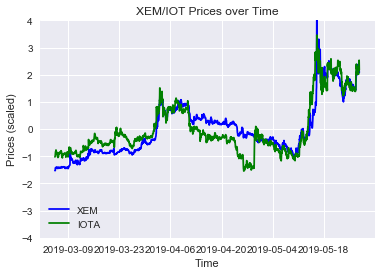

In [26]:
# Scaling and visualizing XEM_IOT

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
df_plot = pd.DataFrame(index=df.index)
df_plot['XEM'] = sc_x.fit_transform(df['XEM'].values.reshape(-1,1))
df_plot['IOTA'] = sc_x.fit_transform(df['MIOTA'].values.reshape(-1,1))

# Plot 1- scaled overlay plot of DASH/ETH prices 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(df.index, df_plot['XEM'], color='blue')
plt.plot(df.index, df_plot['IOTA'], color='green')
#plt.xlim(('2017-09-15', '2017-10-15'))
plt.ylim((-4, 4))
plt.legend(loc='lower left')
plt.xlabel('Time')
plt.ylabel('Prices (scaled)')
plt.title('XEM/IOT Prices over Time')
plt.show()

In [31]:
# Performing Granger Test on XEM_IOT, with maxlag = 50

highest_cor = sm.grangercausalitytests(df_plot, 50)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.2821 , p=0.0000  , df_denom=1997, df_num=1
ssr based chi2 test:   chi2=20.3126 , p=0.0000  , df=1
likelihood ratio test: chi2=20.2101 , p=0.0000  , df=1
parameter F test:         F=20.2821 , p=0.0000  , df_denom=1997, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.3497 , p=0.0000  , df_denom=1994, df_num=2
ssr based chi2 test:   chi2=20.7513 , p=0.0000  , df=2
likelihood ratio test: chi2=20.6443 , p=0.0000  , df=2
parameter F test:         F=10.3497 , p=0.0000  , df_denom=1994, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.3555  , p=0.0000  , df_denom=1991, df_num=3
ssr based chi2 test:   chi2=28.1652 , p=0.0000  , df=3
likelihood ratio test: chi2=27.9685 , p=0.0000  , df=3
parameter F test:         F=9.3555  , p=0.0000  , df_denom=1991, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.9053  , p=0.

ssr based chi2 test:   chi2=178.1939, p=0.0000  , df=29
likelihood ratio test: chi2=170.5972, p=0.0000  , df=29
parameter F test:         F=5.9608  , p=0.0000  , df_denom=1913, df_num=29

Granger Causality
number of lags (no zero) 30
ssr based F test:         F=5.9097  , p=0.0000  , df_denom=1910, df_num=30
ssr based chi2 test:   chi2=182.9536, p=0.0000  , df=30
likelihood ratio test: chi2=174.9538, p=0.0000  , df=30
parameter F test:         F=5.9097  , p=0.0000  , df_denom=1910, df_num=30

Granger Causality
number of lags (no zero) 31
ssr based F test:         F=5.8613  , p=0.0000  , df_denom=1907, df_num=31
ssr based chi2 test:   chi2=187.7039, p=0.0000  , df=31
likelihood ratio test: chi2=179.2919, p=0.0000  , df=31
parameter F test:         F=5.8613  , p=0.0000  , df_denom=1907, df_num=31

Granger Causality
number of lags (no zero) 32
ssr based F test:         F=5.8919  , p=0.0000  , df_denom=1904, df_num=32
ssr based chi2 test:   chi2=194.9777, p=0.0000  , df=32
likelihood ratio 

In [32]:
print(df_plot)
# XEM_IOT Grenger Test results
for key, values in highest_cor.items():
        print('lag', key, '=', values[0]['lrtest'][1])


                          XEM      IOTA
time                                   
2019-03-05 09:00:00 -1.527942 -1.024117
2019-03-05 10:00:00 -1.527942 -1.007069
2019-03-05 11:00:00 -1.526479 -0.987586
2019-03-05 12:00:00 -1.499422 -0.914523
2019-03-05 13:00:00 -1.419713 -0.853638
2019-03-05 14:00:00 -1.443114 -0.821978
2019-03-05 15:00:00 -1.438726 -0.831719
2019-03-05 16:00:00 -1.420444 -0.768398
2019-03-05 17:00:00 -1.410207 -0.829284
2019-03-05 18:00:00 -1.413132 -0.824413
2019-03-05 19:00:00 -1.407282 -0.863380
2019-03-05 20:00:00 -1.420444 -0.887734
2019-03-05 21:00:00 -1.432145 -0.882863
2019-03-05 22:00:00 -1.429951 -0.914523
2019-03-05 23:00:00 -1.423370 -0.885298
2019-03-06 00:00:00 -1.397775 -0.863380
2019-03-06 01:00:00 -1.424101 -0.992457
2019-03-06 02:00:00 -1.431414 -0.994892
2019-03-06 03:00:00 -1.443845 -1.009505
2019-03-06 04:00:00 -1.451158 -1.014375
2019-03-06 05:00:00 -1.446770 -1.046036
2019-03-06 06:00:00 -1.422638 -1.033859
2019-03-06 07:00:00 -1.421176 -1.009505


In [14]:
#XEM_IOT.to_csv('xem_iot.csv')

### Conclusions: 
We performed Granger Causality Test on all of the 132 possible pairs contructed from the 12 "most popular" coins. DASH_BCH was previously selected as the cointegrated pair with the strongest correlation. However, with further research, we found out that the strong correlation was due to surge in Korean trading. Therefore, we instead picked XEM_IOT as our cointegrated pair since it has the strongest correlation under normal condition. For the purpose of this project, IOT historical prices will be used as one of XEM price predictors in a machine learning model. 